# House Price, Earning and Population Relationship Analysis in New Zealand

## Yonghui Rao 16093645

# Introduction

## Background

New Zealand has the world’s most frenetic property market, with prices in Auckland now outstripping London, and possibly dashing the hopes of British buyers hoping to escape Brexit.

In a global ranking of house price growth by estate agents Knight Frank, New Zealand was second to Turkey, but once the impact of inflation was stripped out it came top with 11% annual growth.

## Purpose

This article aims to analyse the current situation of house price in New Zealand, It also tries to find out the relationship between house price, population and earning. The population, earning and house price will be predicted by different models, at last the preediction of average house price in 2017 is provided.

## Research Questions

1. Which city has the highest and lowest house price in NZ?
2. Is there a strong relationship between house price and population in NZ?
3. Is there a strong relationship between earning price and population in NZ?
4. What is the predicted population of major regions in NZ?
5. What is the predicted average weekly earning of major regions in NZ?
6. What is the predicted average house price of NZ in 2017?

## Data Sources

https://www.qv.co.nz/property-trends/residential-house-values

http://www.stats.govt.nz/

http://www.multpl.com/new-zealand-population-growth-rate/table/by-year

## Other Information

1. This notebook may take a few munutes to finish running all cells, because there are 20+ requests to collect house price data.
2. Earning and population data is contained in a csv file which is downloaded from http://www.stats.govt.nz/

## Main Findings
The analysis shows that Auckland, North Shore City and Manukau are top 3 cities which have the highest house price recently, while Invercargill, Dunedin and Napier provide lowest house price. The average earning increase following a linear model based on date but population of major regions does not. The house price holds a strong relationships with both population and earning. The population, earning and house price will all increase in 2017 by prediction.


# Data Analysis

In [1]:
import requests                 # How Python gets the webpages
from bs4 import BeautifulSoup   # Creates structured, searchable object
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from time import sleep


import matplotlib as mpl
import seaborn as sns
import numpy as np
import datetime as dt

import statsmodels.formula.api as smf
import mpld3
from sklearn import preprocessing


In [2]:
import patsy

In [3]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import math 
from sklearn import neighbors

%matplotlib inline

In [4]:
pd.options.display.max_columns = 50
from pylab import rcParams

sns.set(style="ticks")
#sns.set_style("whitegrid")
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams['figure.figsize'] = 10,8
rcParams['font.size'] = 20

In [5]:
rcParams['axes.labelsize'] = 'medium'
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15


In [6]:
# Globle variables for predict house price of 2017 in last chapter
population_growth_rate_mod = 0         # population_growth_rate_mod is kNN distance model for population growth rate
earning_mod = 0                        # earning_mod is linear model for earning
house_price_population_earning_mod = 0 # house_price_population_earning_mod is kNN distance model for house price based on population and warning

## House Price

House Price data is colocted from 'https://www.qv.co.nz/property-trends/residential-house-values', it is shown by month so it is needed to send several requests.  it may take a few minutes to finish all requests.

### House Price - Prepare Data

In [7]:
# The website could only provide the information between year 2013 to 2017, each request could receive 2 months data.
months = range(0,12,2)
years = range (2013, 2018)

# To collect all data there will be several requests, it may take a few minutes to finish
url = 'https://www.qv.co.nz/property-trends/residential-house-values'
dataFrameList = []
for year in years:
    for month in months:
        payload = {'subop': '', 'area': 'All', 'month1': str(month), 'year1': str(year), 'compare': 'compare', 'month2': str(month+1),'year2':str(year)}
        r = requests.post(url, data=payload)
        scraping_html = BeautifulSoup(r.content,'html.parser')
        html_table = scraping_html.find_all("table", {"class": "table table-striped table-bordered tablesorter custom-margin-toptable"})
        df = pd.read_html(str(html_table))
        if len(df[0].dropna()) > 0 :
            dataFrame = df[0].dropna()
            col1 = 'Area'
            col2 = str(month+1)+'/01/'+str(year)  # month in the request starts from 0, convert it to real month
            col3 = str(month+2)+'/01/'+str(year)
            # Make sure it has 2 digits
            if(len(str(month+1)) == 1):
                col2 = '0'+str(month+1)+'/01/'+str(year)
            if(len(str(month+2)) == 1):
                col3 = '0'+str(month+2)+'/01/'+str(year)
            col4 = 'Change'
            dataFrame.columns = [col1,col2,col3,col4]
            dataFrame.drop(col4, axis=1, inplace=True)
            dataFrameList.append(dataFrame)

/home/yrao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
print 'Data frame length is',len(dataFrameList)
dataFrameList[4].head(10)  

Data frame length is 27


Area     09/01/2013  \
0                \n\n New Zealand\n \t\nNew Zealand\n  \n $452,535\n   
2   \n\n - Main Urban Areas\n \t\n - Main Urban Ar...  \n $522,966\n   
4       \n\n - Auckland Area\n \t\n - Auckland Area\n  \n $662,976\n   
6   \n\n - Wellington Area\n \t\n - Wellington Area\n  \n $447,325\n   
8   \n\n Far North District\n \t\nFar North Distri...  \n $296,409\n   
10  \n\n Whangarei District\n \t\nWhangarei Distri...  \n $328,097\n   
12     \n\n Kaipara District\n \t\nKaipara District\n  \n $317,135\n   
14       \n\n Rodney District\n \t\nRodney District\n  \n $615,771\n   
16  \n\n - Rodney - Hibiscus Coast\n \t\n - Rodney...  \n $610,588\n   
18    \n\n - Rodney - North\n \t\n - Rodney - North\n  \n $620,813\n   

       10/01/2013  
0   \n $457,312\n  
2   \n $530,315\n  
4   \n $676,053\n  
6   \n $446,281\n  
8   \n $298,319\n  
10  \n $330,727\n  
12  \n $320,450\n  
14  \n $621,232\n  
16  \n $616,044\n  
18  \n $625,935\n

The original data contains many meanless characters, extract useful part.

In [9]:
import re
def extractArea(x):
    #your code here:
    x=x.replace("\\t","@").replace("\\n","@")
    result=''
    substrs= re.split('@',x)
    if len(substrs) > 0:
        for substr in substrs:
            substr = substr.lstrip()
            if(len(substr) > 2):
                result = substr
                break
    return result

In [10]:
# Remove meaningless chars for "Area" field
# Convert price filed to integer
for df in dataFrameList:
    df['Area']=df['Area'].apply(lambda x: extractArea(x))
    colMonth1 = df.columns[1]
    colMonth2 = df.columns[2]
    df[colMonth1].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
    df[colMonth2].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
    df[colMonth1] = pd.to_numeric(df[colMonth1], errors='coerce')
    df[colMonth2] = pd.to_numeric(df[colMonth2], errors='coerce')
dataFrameList[0].head()

Area  01/01/2013  02/01/2013
0         New Zealand      426452      428692
2  - Main Urban Areas      487000      489998
4     - Auckland Area      607439      610289
6   - Wellington Area      439235      440625
8  Far North District      312522      312034

In [11]:
# Reset index
for i in range(0, len(dataFrameList)):
    dataFrameList[i] = dataFrameList[i].reset_index(drop=True)

Each data frame contains two months information, combine all the dataframes to generate the final house price data for further processing.

In [12]:
#Combain all house price data
df_house_price = dataFrameList[0]
for i in range(1, len(dataFrameList)):
    df_house_price = pd.merge(df_house_price, dataFrameList[i])
    
# Now we get the final house price data for whole new zealand from 2013 to 2017
df_house_price.head()

Area  01/01/2013  02/01/2013  03/01/2013  04/01/2013  \
0         New Zealand      426452      428692      429061      431967   
1  - Main Urban Areas      487000      489998      491124      495488   
2     - Auckland Area      607439      610289      612133      619457   
3   - Wellington Area      439235      440625      442206      442732   
4  Far North District      312522      312034      306736      310057   

   05/01/2013  06/01/2013  07/01/2013  08/01/2013  09/01/2013  10/01/2013  \
0      436097      441254      445247      448929      452535      457312   
1      501364      506703      511625      516417      522966      530315   
2      631174      639385      644973      652129      662976      676053   
3      444085      444691      445899      445784      447325      446281   
4      312993      310484      310523      310589      296409      298319   

   11/01/2013  12/01/2013  01/01/2014  02/01/2014  03/01/2014  04/01/2014  \
0      460067      466022      467499      468484      466665      468383   
1      534852      542136      543745      544360      542932      546466   
2      685350      693549      695215      695499      699659      705867   
3      448325      451200      452427      453493      454530      455214   
4      300517      300874      300444      302551      302077      304538   

   05/01/2014  06/01/2014  07/01/2014  08/01/2014  09/01/2014  10/01/2014  \
0      471791      476346      479193      479967      481497      484307   
1      550167      555521      558131      559890      561762      566435   
2      713709      718285      720426      726627      731302      738083   
3      452099      452649      451154      449838      448644      449913   
4      298087      296275      296816      300458      304327      305070   

   11/01/2014  12/01/2014     ...      06/01/2015  07/01/2015  08/01/2015  \
0      483424      488674     ...          520585      527760      534331   
1      567526      575053     ...          619250      628722      637912   
2      748955      761858     ...          840165      855672      874851   
3      450447      453366     ...          459366      458250      457266   
4      306122      308125     ...          307368      312903      318869   

   09/01/2015  10/01/2015  11/01/2015  12/01/2015  01/01/2016  02/01/2016  \
0      542277      552345      555729      558146      556206      556306   
1      649583      664096      667220      669091      664401      663652   
2      896676      918153      931807      933264      928921      925656   
3      456281      461571      468902      476634      482716      485424   
4      319072      322542      328038      328687      328622      330904   

   03/01/2016  04/01/2016  05/01/2016  06/01/2016  07/01/2016  08/01/2016  \
0      559492      568058      577829      590909      602434      612527   
1      667102      677322      688908      706477      722243      734515   
2      931061      942760      955793      975087      992207     1013632   
3      491236      496812      504794      516430      524063      536065   
4      336333      343135      345895      351792      355485      365085   

   09/01/2016  10/01/2016  11/01/2016  12/01/2016  01/01/2017  02/01/2017  \
0      619660      622309      624675      627905      631302      631349   
1      743012      747507      751113      751460      754572      750253   
2     1031253     1045207     1051387     1047179     1047699     1043680   
3      553023      558886      565631      574410      582322      589784   
4      370088      359876      367005      376947      389811      399780   

   03/01/2017  04/01/2017  05/01/2017  06/01/2017  
0      631432      631147      634018      639051  
1      748957      746641      748592      751563  
2     1045362     1043830     1044561     1045059  
3      595501      602230      607907      609552  
4      397600      401968      402966      408416  

[5 rows x 55 columns]

### House Price - Data Analysis

df_house_price contains house price information by regions, extract the major cities. 

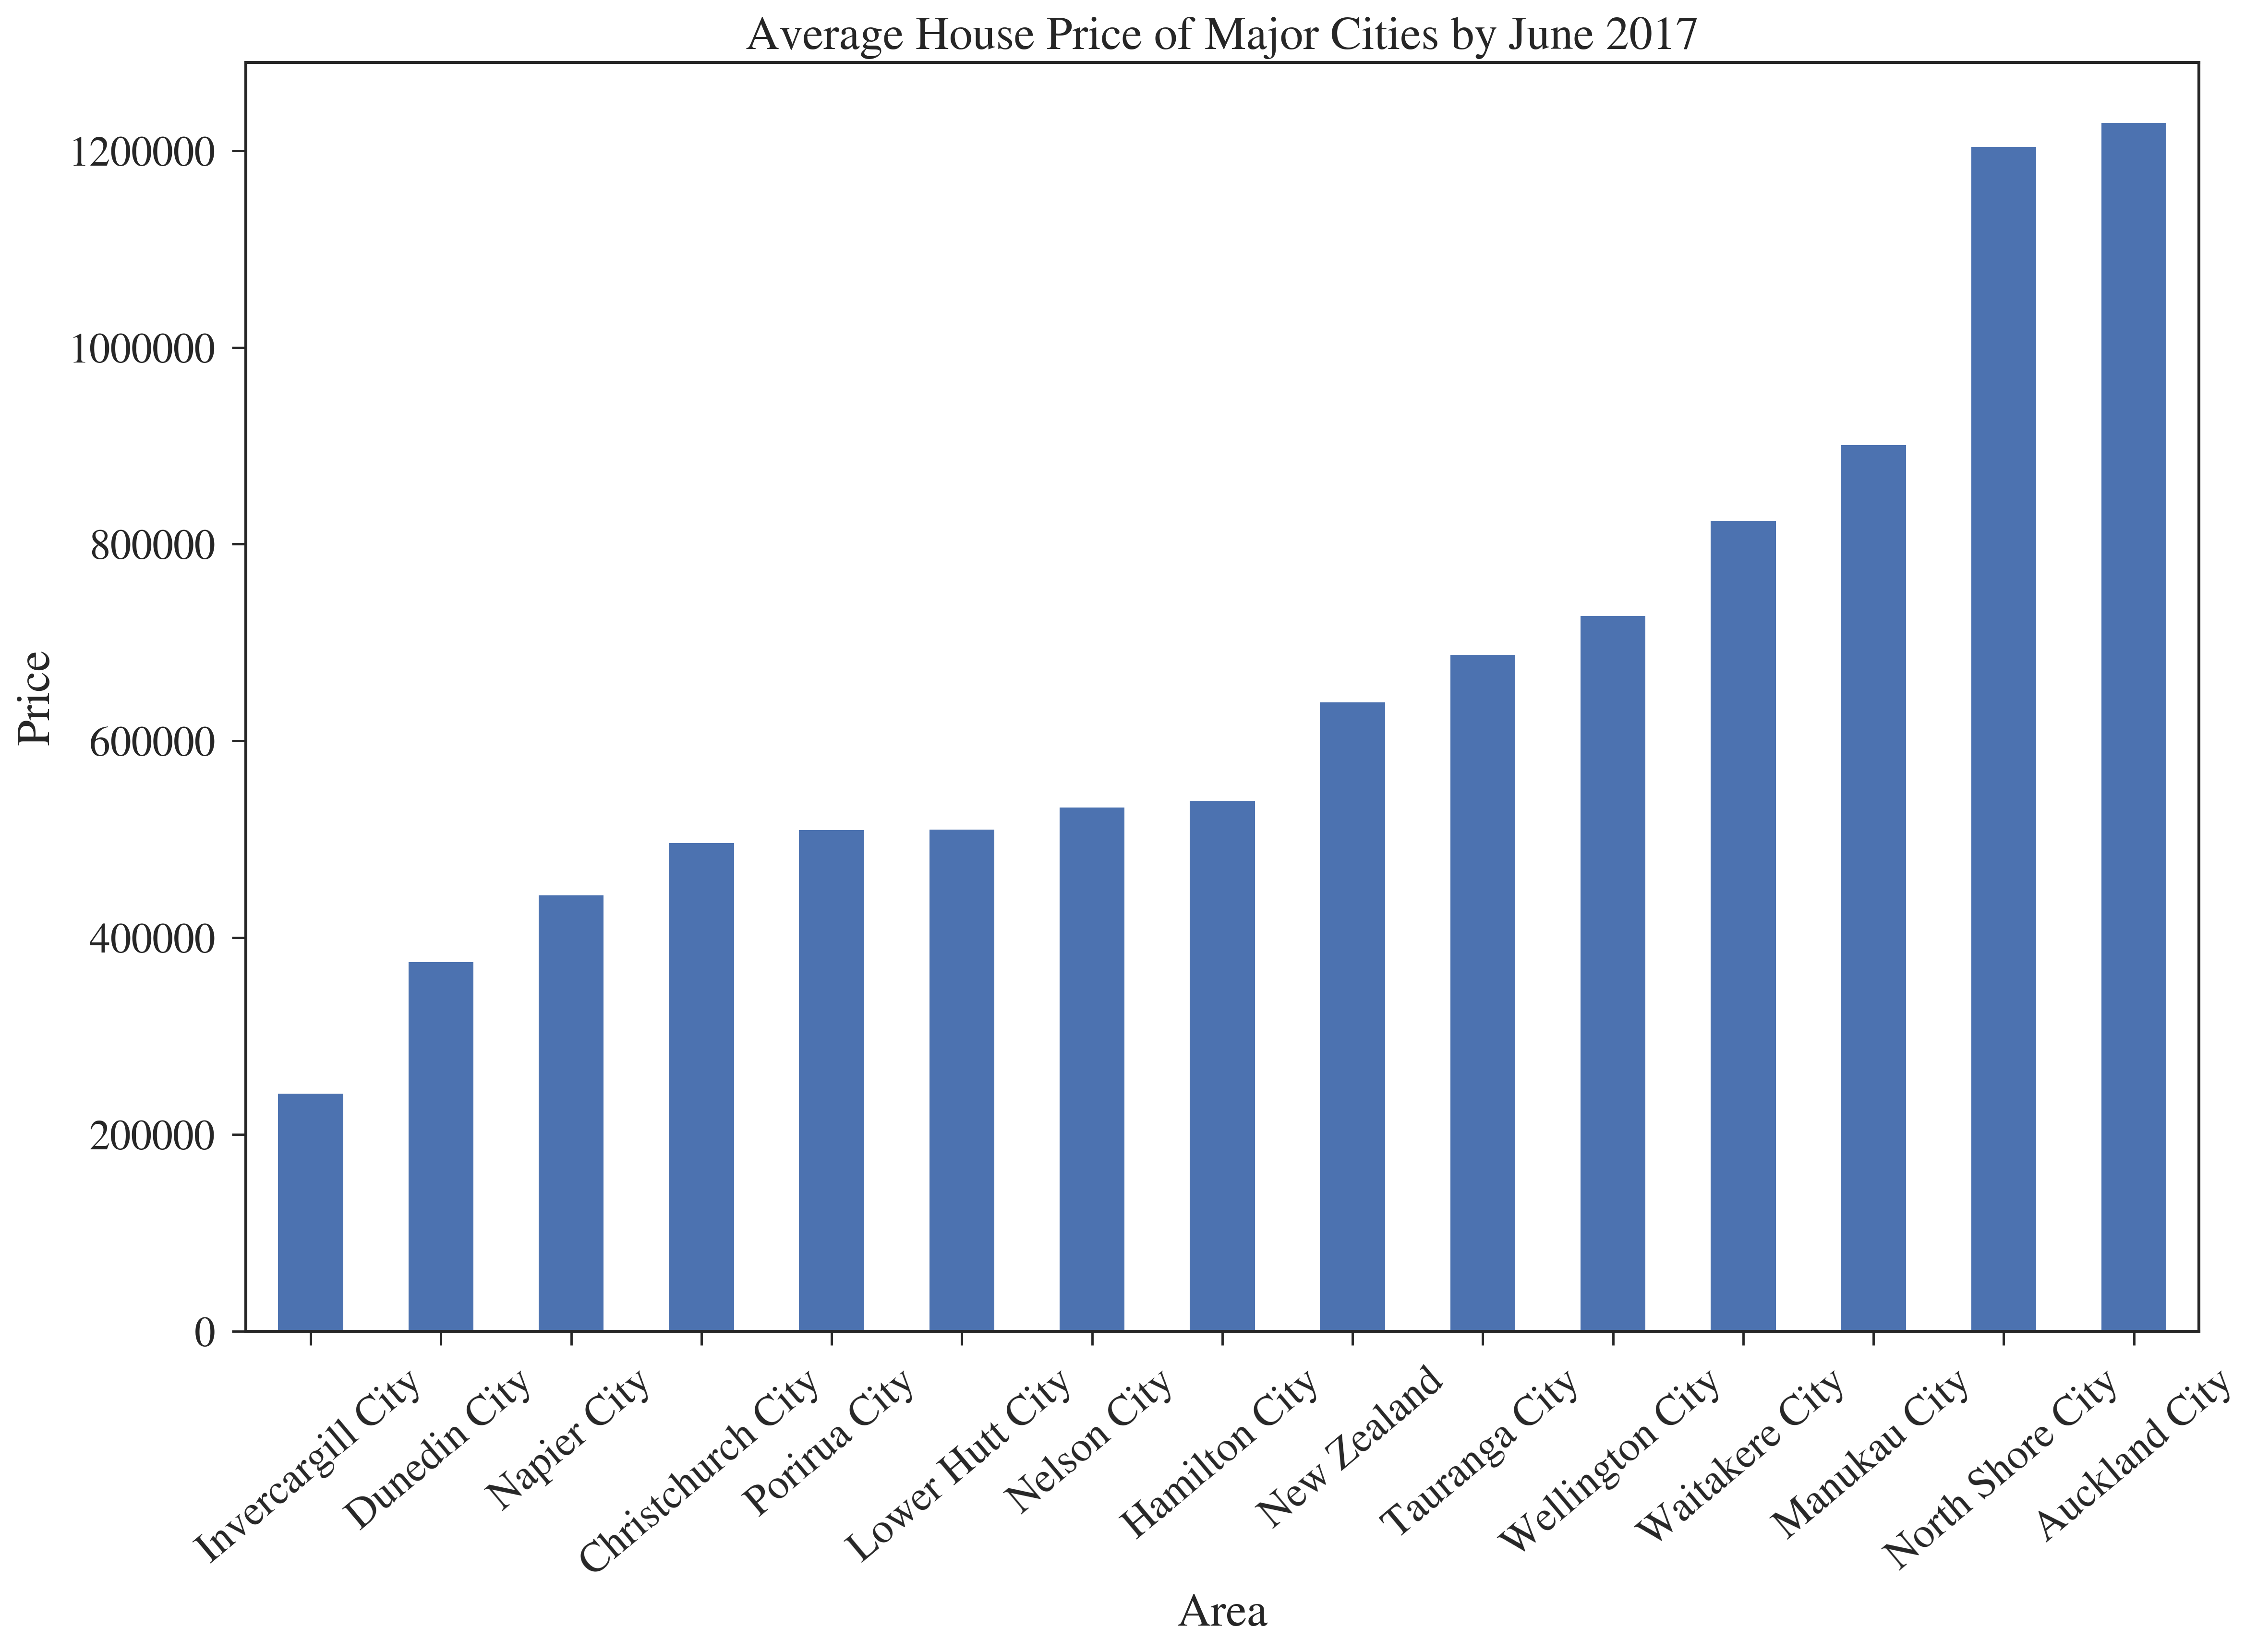

In [13]:
#Show the recent house prices by major city       
major_regions = ['North Shore City',
                 'Waitakere City',
                 'Auckland City',
                 'Manukau City',
                 'Hamilton City',
                 'Tauranga City',
                 'Napier City',
                 'New Zealand',
                 'Porirua City',
                 'pper Hutt City',
                 'Lower Hutt City',
                 'Wellington City',
                 'Nelson City',
                 'Christchurch City',
                 'Dunedin City',
                 'Invercargill City']
df = df_house_price[df_house_price['Area'].isin(major_regions)]

df = df.sort_values(['06/01/2017'], ascending=[True])
x = df['Area']
y = df['06/01/2017']
ax=df[['Area','06/01/2017']].plot(kind='bar', figsize=(15, 10), legend=False, fontsize=18, x=df['Area'], rot=40)
ax.set_xlabel('Area', fontsize=20)
ax.set_ylabel('Price', fontsize=20)
ax.set_title('Average House Price of Major Cities by June 2017', fontsize=20)                             

The figure shows that Auckland, North Shore City and Manukau are top 3 cities which have the highest house price recently, while Invercargill, Dunedin and Napier provide lowest house price. 
In Auckland, it may costs more than 1.2 million NZD to purchase a house.

Because Auckland is the largest city which has more than 1 million population, the house price of both Auckland and whole NZ will be analysed.

In [14]:
price = df_house_price[df_house_price['Area'] == 'New Zealand']
price

Area  01/01/2013  02/01/2013  03/01/2013  04/01/2013  05/01/2013  \
0  New Zealand      426452      428692      429061      431967      436097   

   06/01/2013  07/01/2013  08/01/2013  09/01/2013  10/01/2013  11/01/2013  \
0      441254      445247      448929      452535      457312      460067   

   12/01/2013  01/01/2014  02/01/2014  03/01/2014  04/01/2014  05/01/2014  \
0      466022      467499      468484      466665      468383      471791   

   06/01/2014  07/01/2014  08/01/2014  09/01/2014  10/01/2014  11/01/2014  \
0      476346      479193      479967      481497      484307      483424   

   12/01/2014     ...      06/01/2015  07/01/2015  08/01/2015  09/01/2015  \
0      488674     ...          520585      527760      534331      542277   

   10/01/2015  11/01/2015  12/01/2015  01/01/2016  02/01/2016  03/01/2016  \
0      552345      555729      558146      556206      556306      559492   

   04/01/2016  05/01/2016  06/01/2016  07/01/2016  08/01/2016  09/01/2016  \
0      568058      577829      590909      602434      612527      619660   

   10/01/2016  11/01/2016  12/01/2016  01/01/2017  02/01/2017  03/01/2017  \
0      622309      624675      627905      631302      631349      631432   

   04/01/2017  05/01/2017  06/01/2017  
0      631147      634018      639051  

[1 rows x 55 columns]

In [15]:
import matplotlib.dates as mdates
dates = df_house_price.columns[1:]
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
NZPrices_Array = []
AKLPrices_Array=[]
for date in dates:
    NZprice = df_house_price[df_house_price.Area == 'New Zealand'][date]
    NZPrices_Array.append(NZprice.values[0])
    AKLPrice = df_house_price[df_house_price.Area == '- Auckland Area'][date]
    AKLPrices_Array.append(AKLPrice.values[0])

dates_numbers = mpl.dates.date2num(x)


In [16]:
X = dates_numbers
X = np.reshape(X, (len(X), 1))
y = NZPrices_Array
y = np.reshape(y, (len(NZPrices_Array), 1))
x = np.linspace(X.min(), X.max(), 400)[:, np.newaxis]


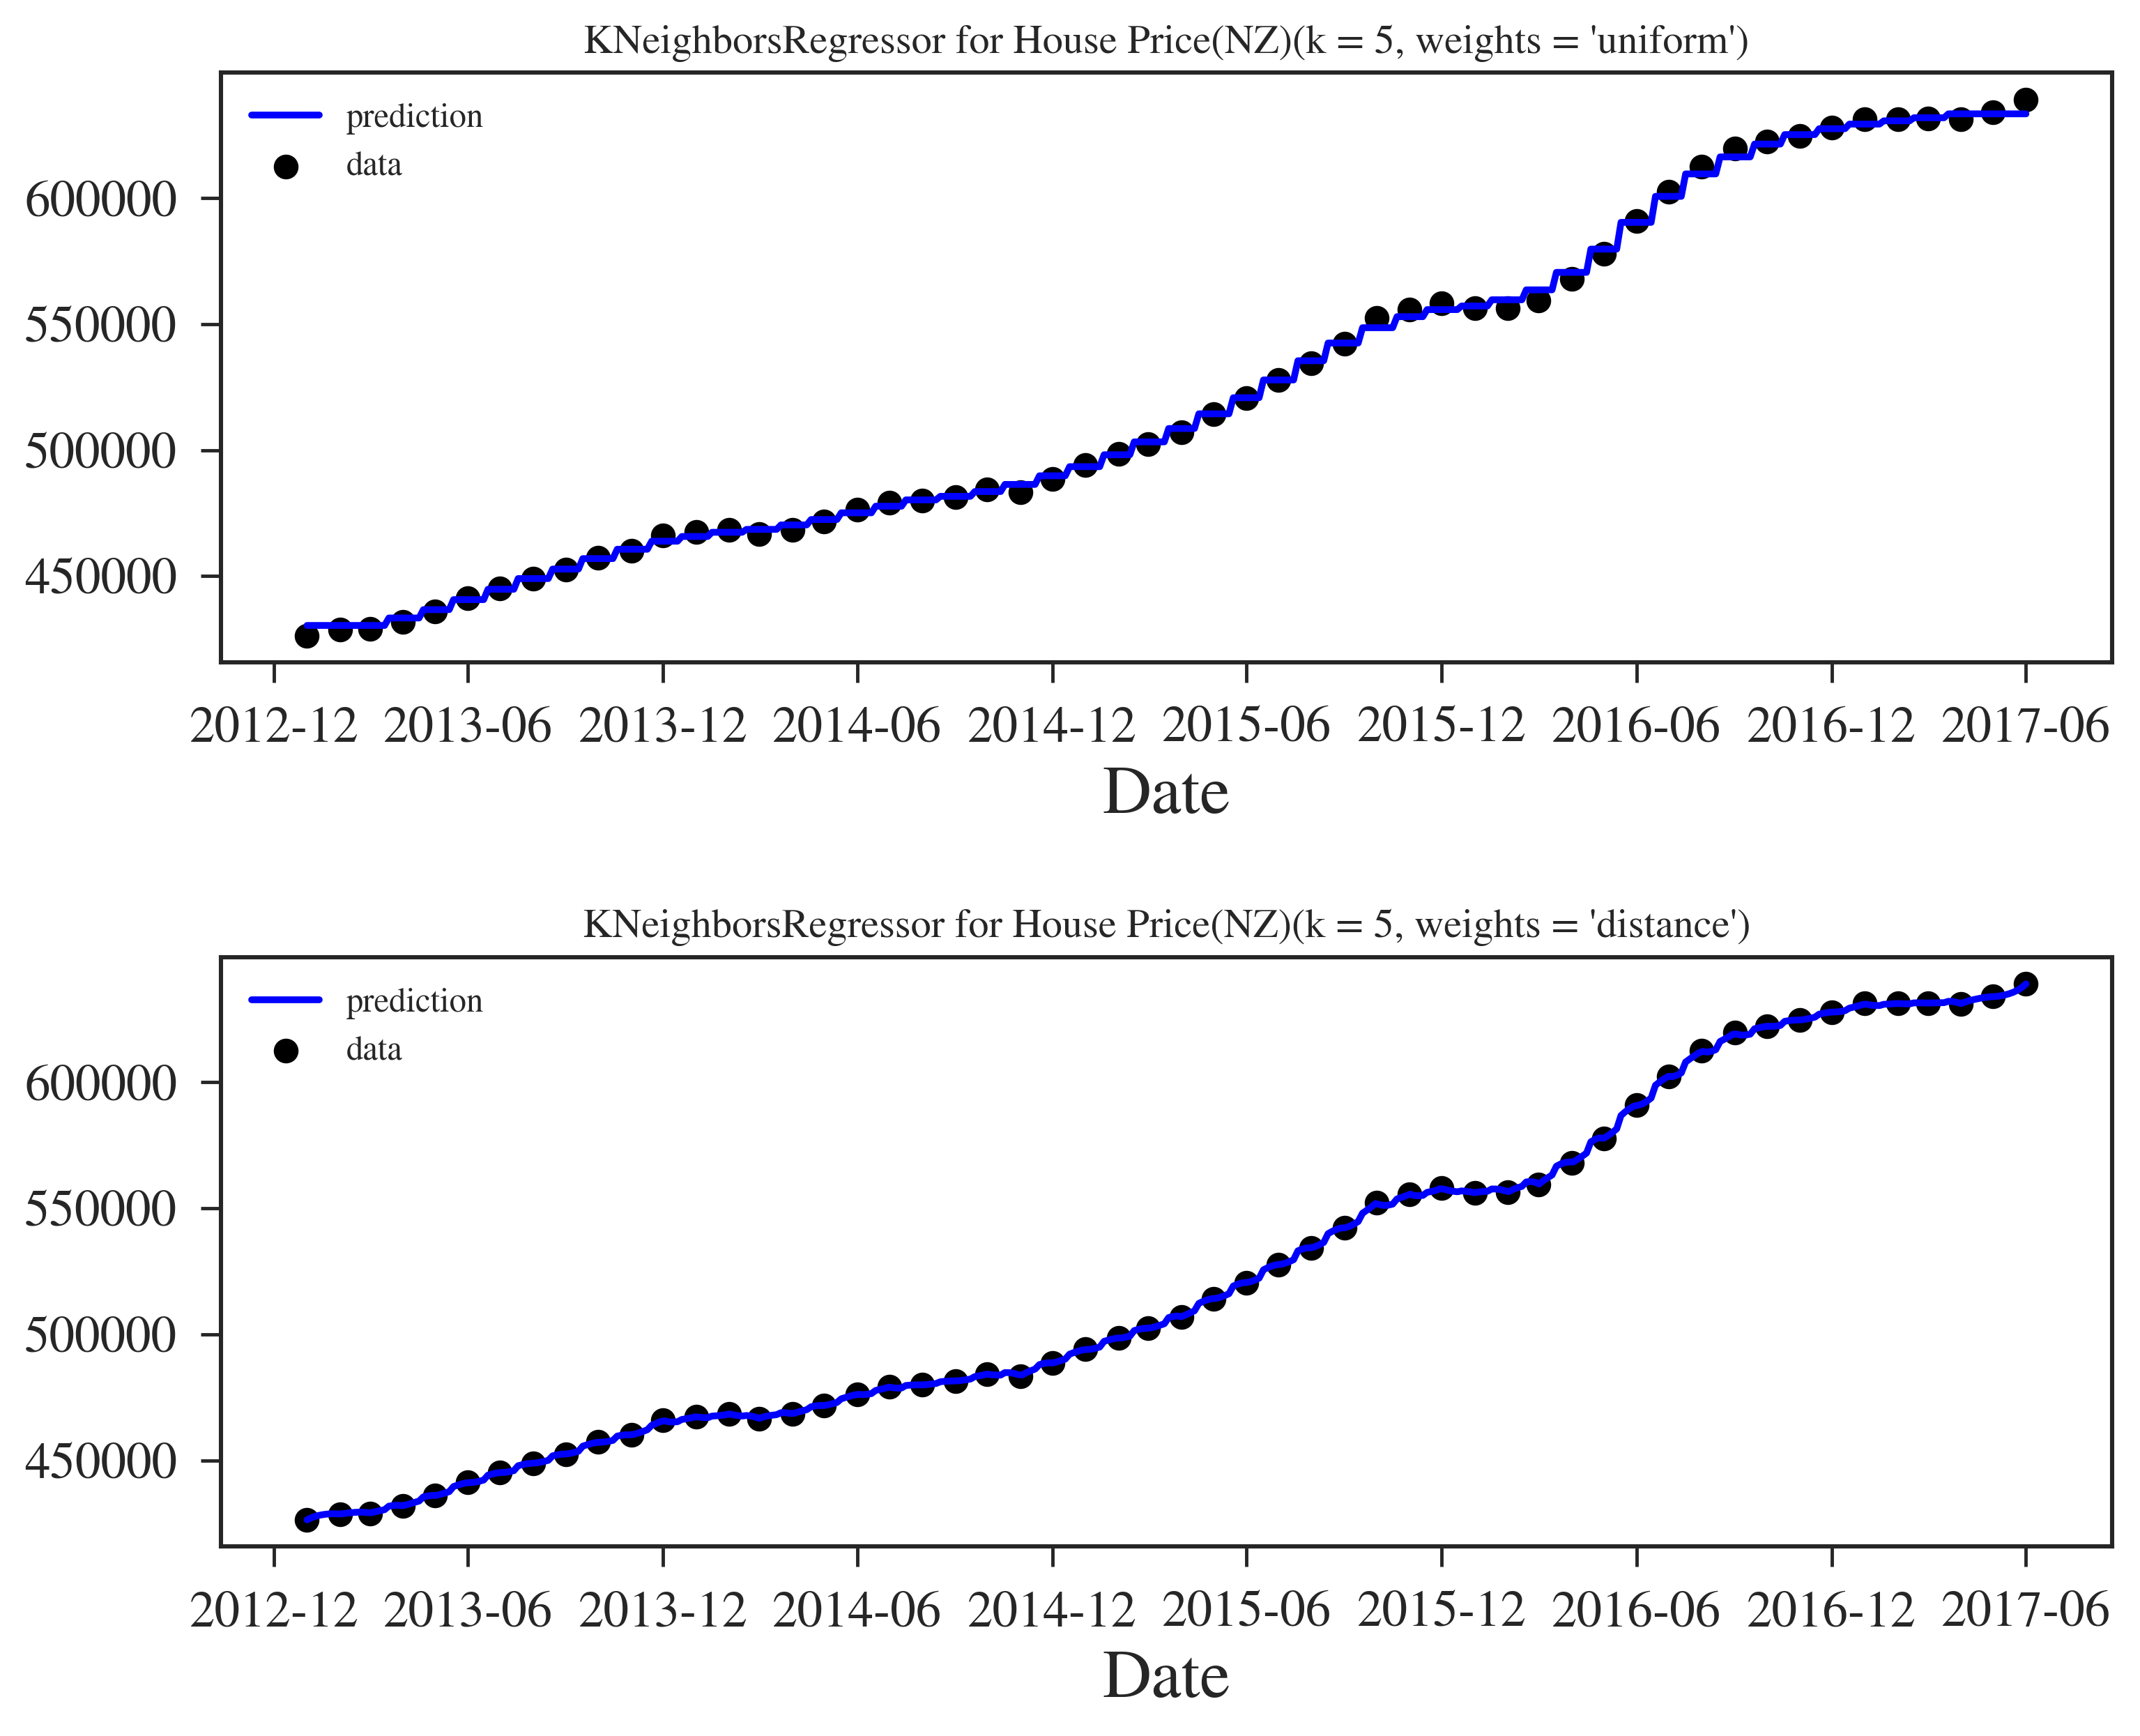

In [17]:
n_neighbors = 5
NZ_house_price_date_mod = 0
for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    NZ_house_price_date_mod = knn.fit(X, y)
    y_hat = NZ_house_price_date_mod.predict(x)
    
    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot_date(x, y_hat, 'b-', c='b', label='prediction')
    plt.axis('tight')
    plt.xlabel('Date')
    plt.legend(loc='upper left')
    plt.title("KNeighborsRegressor for House Price(NZ)(k = %i, weights = '%s')" % (n_neighbors, weights))
    plt.subplots_adjust( hspace=0.5)
    
plt.show()

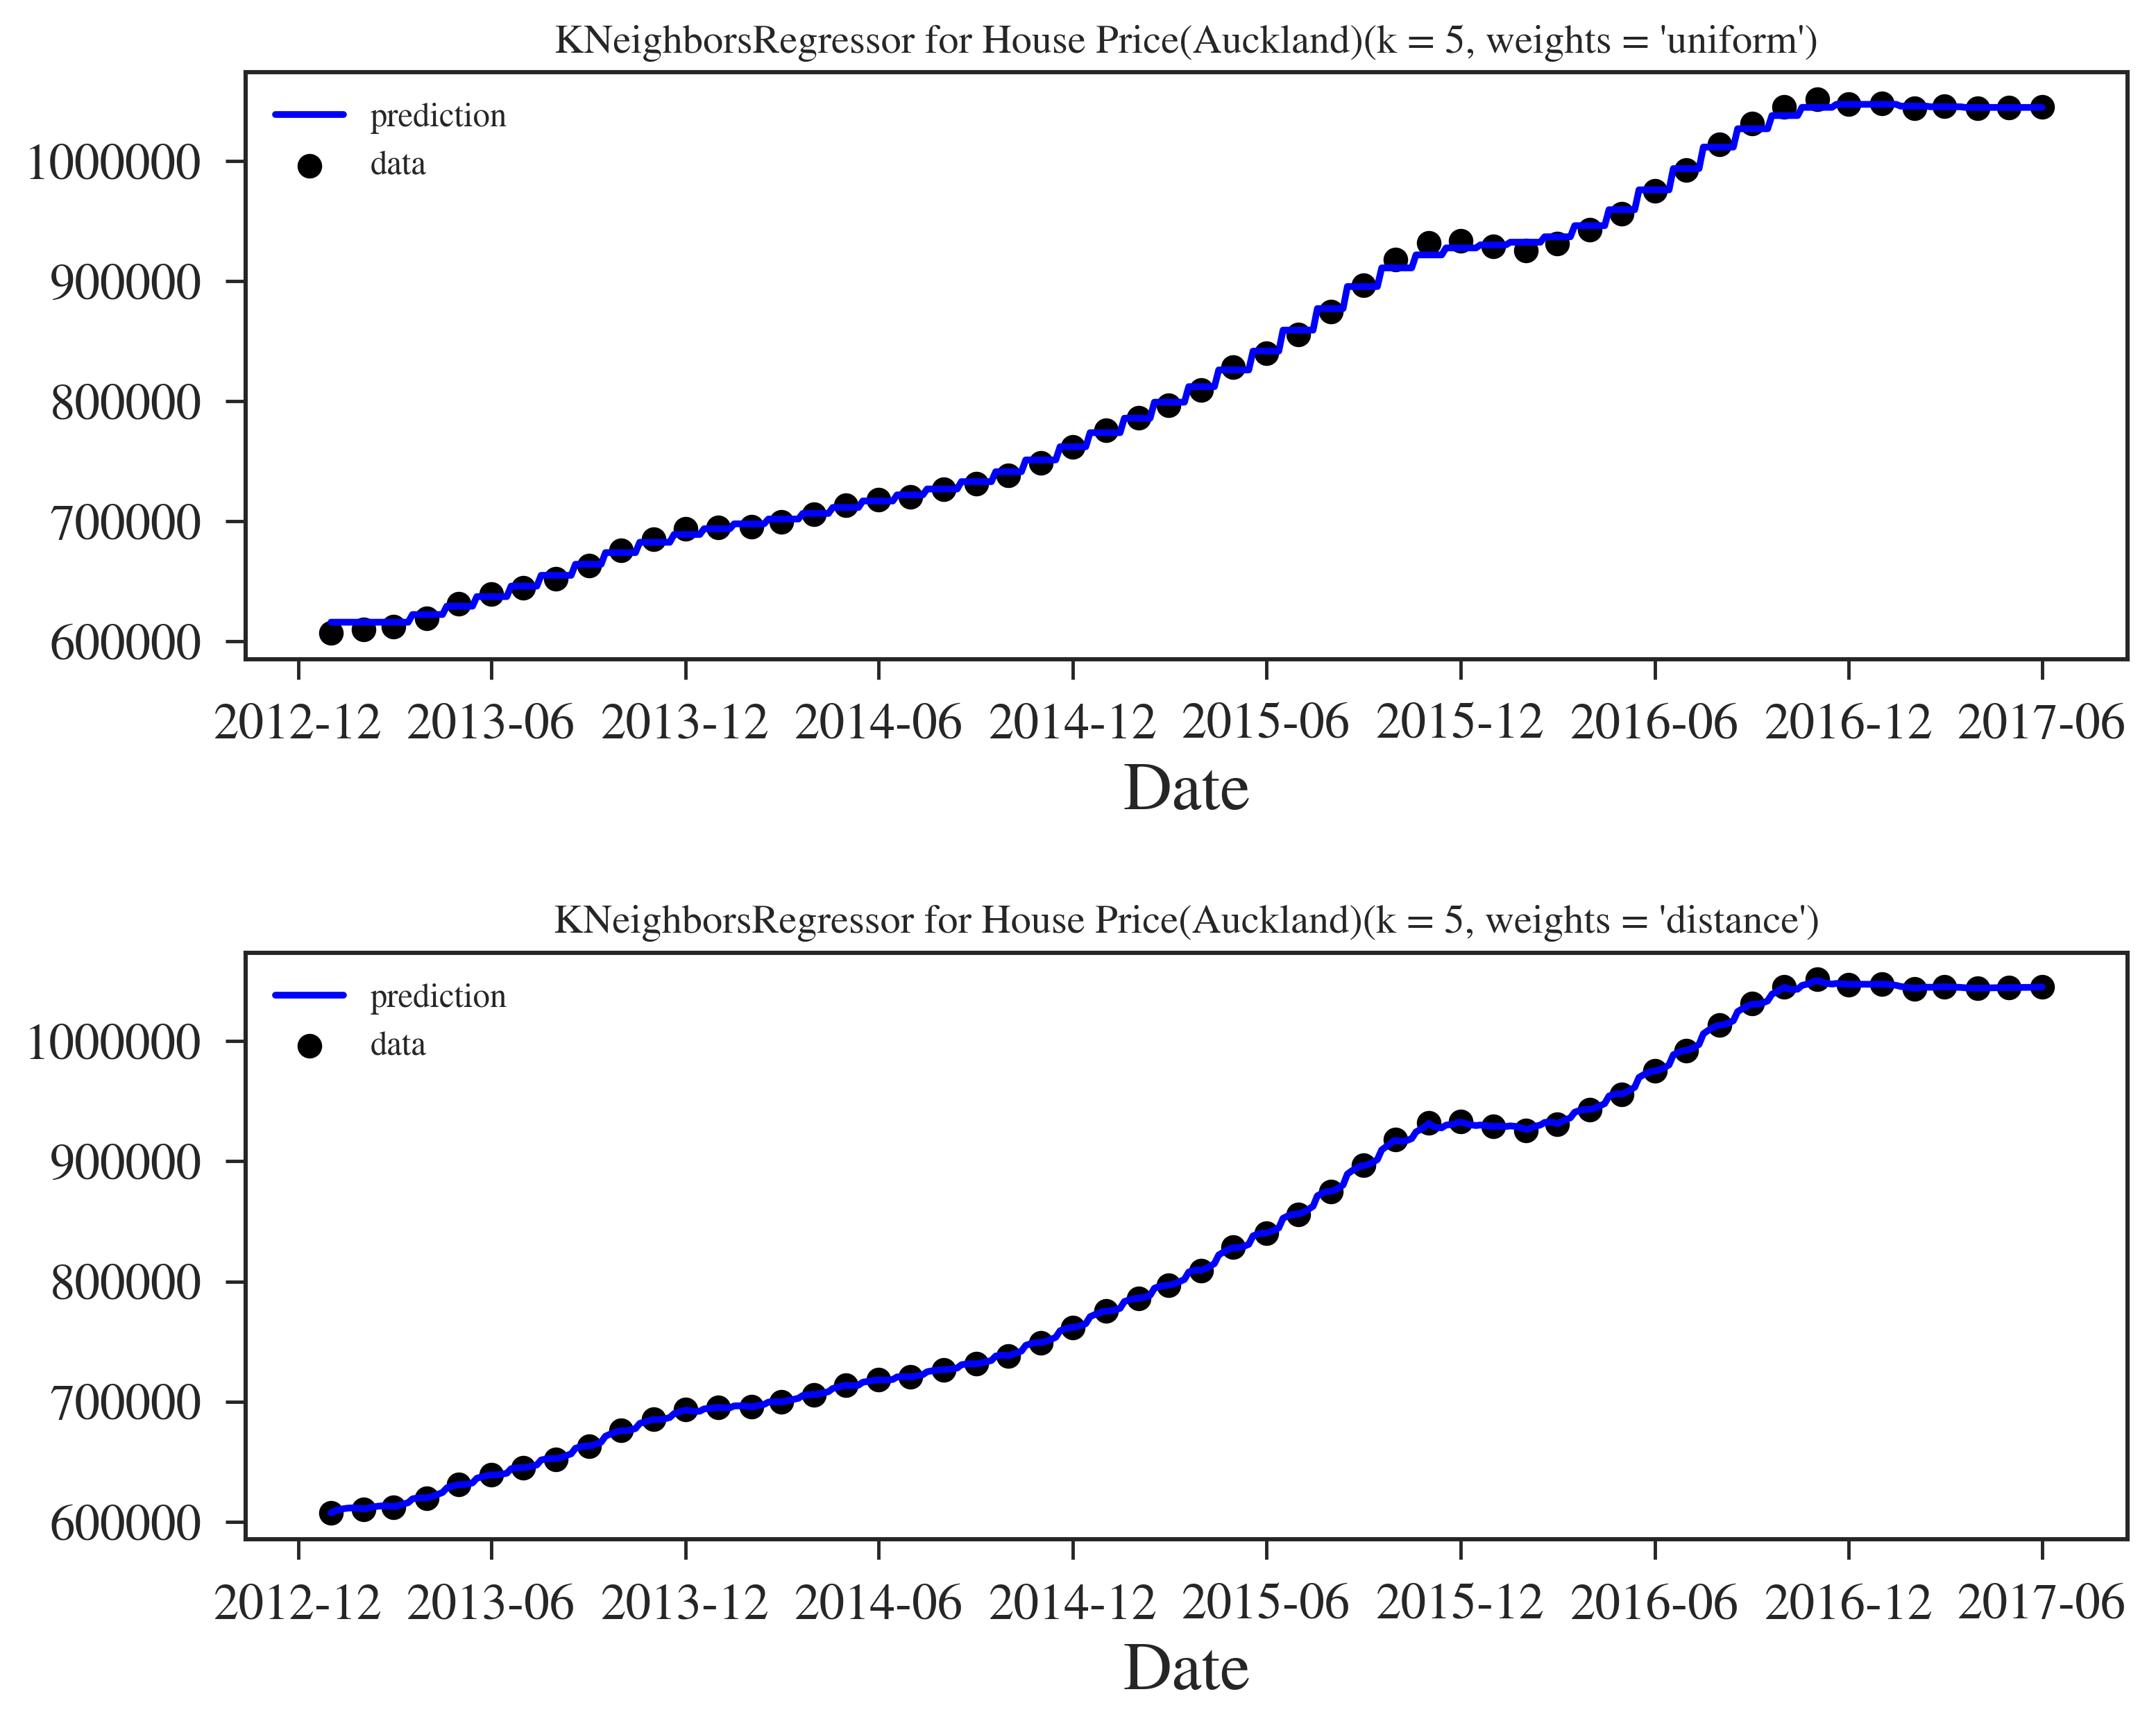

In [18]:
# Fit regression model
y = AKLPrices_Array
y = np.reshape(y, (len(AKLPrices_Array), 1))
n_neighbors = 5
for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_hat = knn.fit(X, y).predict(x)
    
    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot_date(x, y_hat, 'b-', c='b', label='prediction')
    plt.axis('tight')
    plt.xlabel('Date')
    plt.legend(loc='upper left')
    plt.title("KNeighborsRegressor for House Price(Auckland)(k = %i, weights = '%s')" % (n_neighbors, weights))
    plt.subplots_adjust( hspace=0.5)
    
plt.show()

The house price of whole NZ and Auckland did not increae linearly, so kNN models are presented here, it is clearly that the 'distance' weighted model is more smooth thant 'uniform' model.
This model predict the house price value by its neighbours, so it will be more accurate in the middle of the x-axis, it could be used to predict the house price of a specific date in the past, but it is not reliable to predic a futher value.

To predict a future house price, we need a more robust model, in the following, a model considering population and earning will be presented and future house price is predicted by population and earning.

## Earning and Population

To predict future house price from earning and population, we nned to prefict future population and earning firstly, so two models for population and earning are constructed in this section.

### Date prepare - Earning and Population

The data is downloaded from http://www.stats.govt.nz/

In [19]:
earning_populattion_data = pd.io.parsers.read_csv(
    'Earning and Population.csv',
    )
#death_rate_role_data.columns=['Country','vehicles_with_4wheel', 'vehicles_with_2or3wheel','Cyclists', 'Pedestrians','others']
#death_rate_role_data=pd.merge(death_rate_role_data,Vehicles_data)
earning_populattion_data.head(10)

Region            Total Regions              Unnamed: 2  \
0   Year  Average Weekly Earnings  Median Weekly Earnings   
1   1998                      584                     518   
2   1999                      602                     520   
3   2000                      609                     537   
4   2001                      641                     560   
5   2002                      664                     575   
6   2003                      704                     600   
7   2004                      725                     614   
8   2005                      748                     640   
9   2006                      760                     671   

               Unnamed: 3         Northland Region              Unnamed: 5  \
0  Number of People (000)  Average Weekly Earnings  Median Weekly Earnings   
1                  1693.8                      474                     440   
2                  1734.8                      540                     478   
3                  1757.2                      487                     438   
4                  1813.3                      542                     499   
5                  1878.9                      574                     496   
6                  1919.9                      593                     510   
7                  1981.8                      614                     537   
8                  2049.3                      713                     588   
9                  2118.5                      660                     575   

               Unnamed: 6          Auckland Region              Unnamed: 8  \
0  Number of People (000)  Average Weekly Earnings  Median Weekly Earnings   
1                    53.4                      662                     575   
2                    51.9                      665                     575   
3                      57                      701                     600   
4                    57.1                      721                     600   
5                    59.2                      743                     624   
6                    62.2                      803                     671   
7                    62.6                      850                     671   
8                      67                      851                     690   
9                    70.7                      815                     705   

               Unnamed: 9           Waikato Region             Unnamed: 11  \
0  Number of People (000)  Average Weekly Earnings  Median Weekly Earnings   
1                   540.4                      559                     518   
2                   555.4                      541                     484   
3                   555.5                      561                     520   
4                   572.2                      597                     537   
5                   598.6                      633                     575   
6                   612.2                      642                     575   
7                   640.8                      674                     614   
8                   656.1                      717                     666   
9                   683.9                      716                     659   

              Unnamed: 12     Bay of Plenty Region             Unnamed: 14  \
0  Number of People (000)  Average Weekly Earnings  Median Weekly Earnings   
1                   152.8                      545                     500   
2                   161.3                      569                     500   
3                     169                      526                     480   
4                   166.4                      591                     520   
5                   176.4                      597                     543   
6                     184                      659                     575   
7                   189.4                      610                     556   
8                   188.6                      629 

In [20]:
# Adjust the dataframe for further processing

regions = ['Total',                     #Total Regions
           'Northland',                 #Northland Region
           'Auckland',                  #Auckland Region
           'Waikato', 
           'BoP',                       #Bay of Plenty Region
           'GHB',                       #Gisborne/Hawkes Bay Regions
           'Taranaki',
           'Manawatu-Wanganui',
           'Wellington',
           'NTMWC',                     #Nelson/Tasman/Marlborough/West Coast Regions
           'Canterbury',
           'Otago',
           'Southland']
data_titles = ['awe', # Average Weekly Earnings
               'mwe', # Median Weekly Earnings
               'nop'] # Number of People (000)
ep_columns = ['Year'] # new columns names for earning_populattion_data

for region in regions:
    for data_title in data_titles:
        new_colomn = region+'_'+data_title
        ep_columns.append(new_colomn)

earning_populattion_data.columns = ep_columns
# Remove the first row which has no data
earning_populattion_data=earning_populattion_data[earning_populattion_data.index !=0]
# Reset index
earning_populattion_data = earning_populattion_data.reset_index(drop=True)
earning_populattion_data['Year'] = earning_populattion_data['Year'].apply(lambda x: int(x))
earning_populattion_data['Total_awe'] = earning_populattion_data['Total_awe'].apply(lambda x: int(x))
earning_populattion_data['Total_nop'] = earning_populattion_data['Total_nop'].apply(lambda x: float(x))
earning_populattion_data['Auckland_awe'] = earning_populattion_data['Auckland_awe'].apply(lambda x: float(x))
earning_populattion_data['Auckland_nop'] = earning_populattion_data['Auckland_nop'].apply(lambda x: float(x))
earning_populattion_data.head(5)


Year  Total_awe Total_mwe  Total_nop Northland_awe Northland_mwe  \
0  1998        584       518     1693.8           474           440   
1  1999        602       520     1734.8           540           478   
2  2000        609       537     1757.2           487           438   
3  2001        641       560     1813.3           542           499   
4  2002        664       575     1878.9           574           496   

  Northland_nop  Auckland_awe Auckland_mwe  Auckland_nop Waikato_awe  \
0          53.4         662.0          575         540.4         559   
1          51.9         665.0          575         555.4         541   
2            57         701.0          600         555.5         561   
3          57.1         721.0          600         572.2         597   
4          59.2         743.0          624         598.6         633   

  Waikato_mwe Waikato_nop BoP_awe BoP_mwe BoP_nop GHB_awe GHB_mwe GHB_nop  \
0         518       152.8     545     500      98     535     476    76.9   
1         484       161.3     569     500    99.8     535     460    81.7   
2         520         169     526     480     105     539     493      82   
3         537       166.4     591     520     102     576     520    83.5   
4         575       176.4     597     543   108.8     597     540      86   

  Taranaki_awe Taranaki_mwe Taranaki_nop Manawatu-Wanganui_awe  \
0          545          500         44.3                   472   
1          533          460         46.2                   493   
2          543          479         44.6                   535   
3          597          537         47.2                   586   
4          602          519         51.9                   588   

  Manawatu-Wanganui_mwe Manawatu-Wanganui_nop Wellington_awe Wellington_mwe  \
0                   430                  91.8            661            575   
1                   460                  95.5            721            610   
2                   480                  90.9            679            595   
3                   518                  95.5            705            614   
4                   506                 100.1            750            640   

  Wellington_nop NTMWC_awe NTMWC_mwe NTMWC_nop Canterbury_awe Canterbury_mwe  \
0          214.5       473       435      73.2            508            462   
1          206.1       491       440      73.1            578            498   
2            220       517       480      74.3            575            500   
3          230.3       548       500      78.8            575            520   
4          227.9       594       534      78.3            607            537   

  Canterbury_nop Otago_awe Otago_mwe Otago_nop Southland_awe Southland_mwe  \
0          216.5       517       480      87.7           620           537   
1          232.3       519       468      85.4           528           450   
2          231.8       489       448      84.6           554           527   
3          248.8       560       510      86.7           653           550   
4            255       552       504        92           637           575   

  Southland_nop  
0          44.3  
1          46.2  
2          42.5  
3          44.8  
4          44.7

### Data Analysis - Population

First, we try to present a model to predict population of all major regions based on Year.

/home/yrao/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Total_nop   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     171.0
Date:                Wed, 30 Aug 2017   Prob (F-statistic):           2.67e-10
Time:                        19:22:29   Log-Likelihood:                -104.34
No. Observations:                  19   AIC:                             212.7
Df Residuals:                      17   BIC:                             214.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -6.62e+04   5218.193    -12.686      0.000   -7.72e+04   -5.52e+04
Year          34.0030      2.600     13.078      0.000      28.517      39.488
==============================================================================
Omnibus:                        1.994   Durbin-Watson:                   0.397
Prob(Omnibus):                  0.369   Jarque-Bera (JB):                1.274
Skew:                           0.364   Prob(JB):                        0.529
Kurtosis:                       1.961   Cond. No.                     7.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

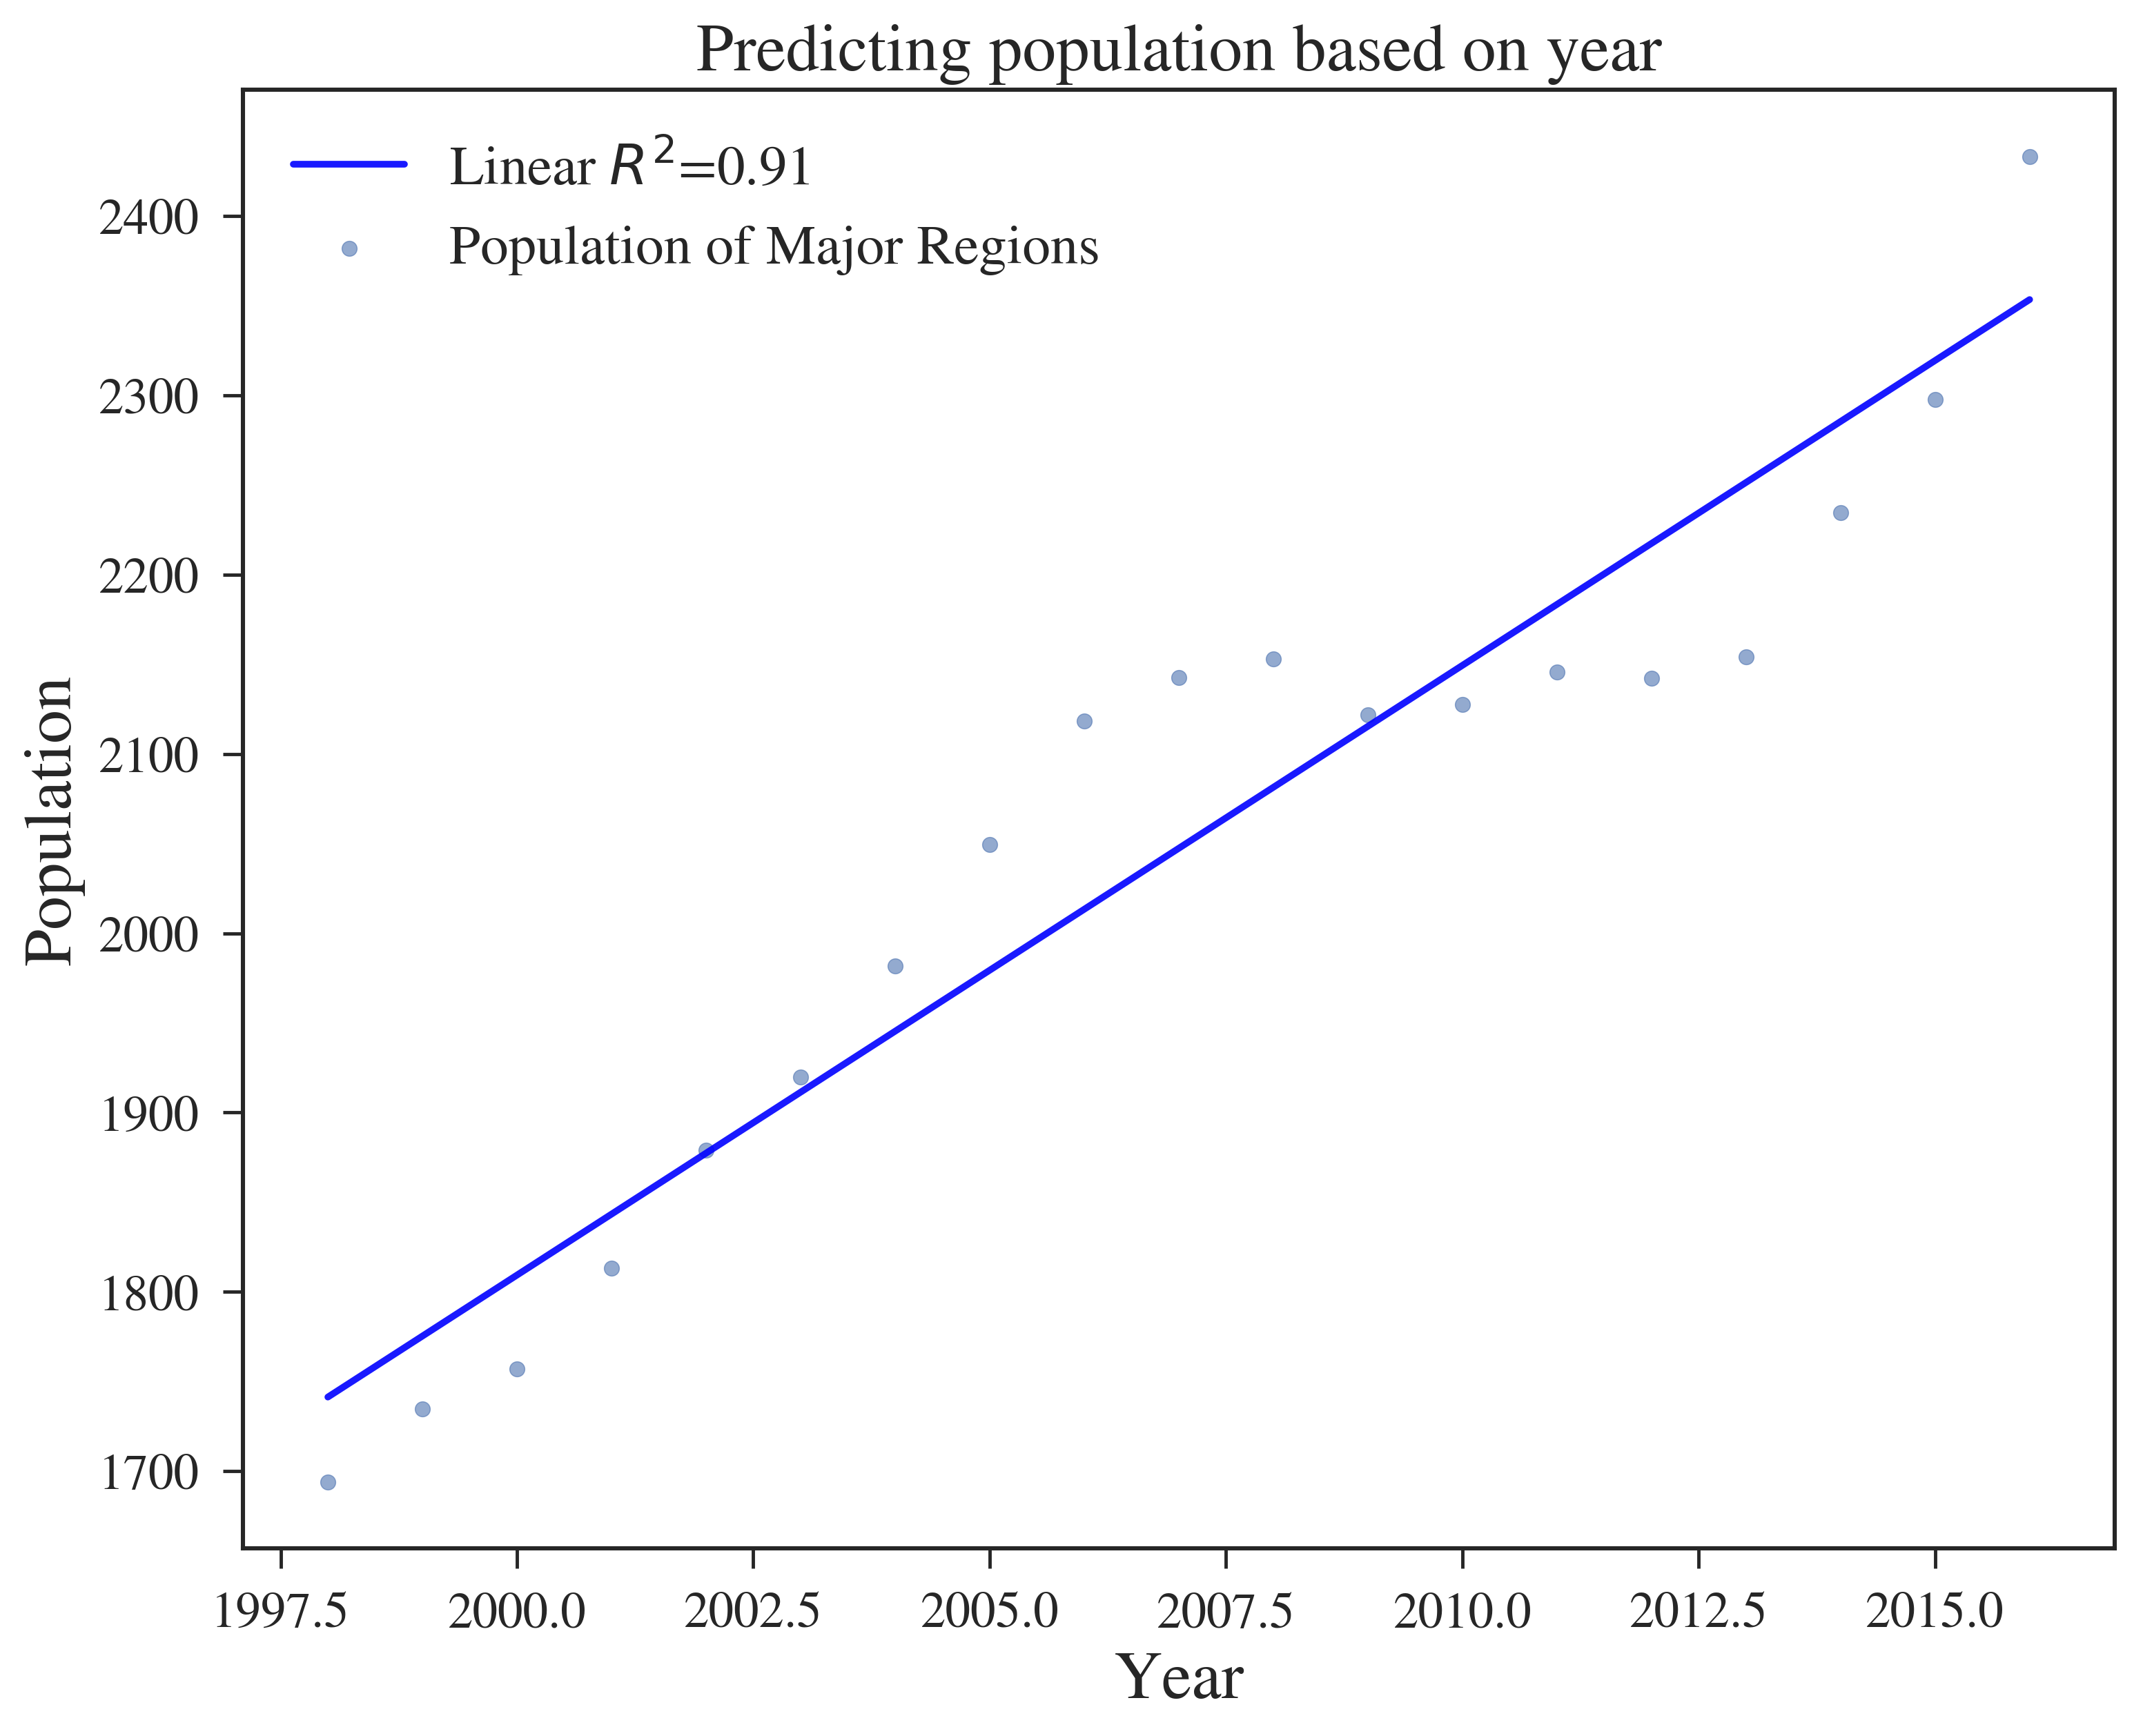

In [21]:
x = pd.DataFrame({'Year': np.linspace(earning_populattion_data['Year'].min(), earning_populattion_data['Year'].max(), len( earning_populattion_data['Year']))})

#generate the model which uses the course work score to predict the exan mark - the ols() return the generated model
mod = smf.ols(formula='Total_nop ~ 1 + Year', data=earning_populattion_data.dropna()).fit()

#plot the actual data
plt.scatter(earning_populattion_data.Year, earning_populattion_data.Total_nop, s=20, alpha=0.6, label='Population of Major Regions')
plt.xlabel('Year'); plt.ylabel('Population')
plt.plot(earning_populattion_data.Year, mod.predict(x), 'b-',  label='Linear $R^2$=%.2f' % mod.rsquared, alpha=0.9)

#give the figure a meaningful legend
plt.legend(loc='upper left', framealpha=0.5, prop={'size':'small'})
plt.title("Predicting population based on year", fontsize=20)

mod.summary()

Though R-squared is 0.91, the population value does not follow our model very well, it may be not reliable to predict population with this model. An alternative approach is estimate population by population growth rate, this will be introduced in next section.

### Data Analysis - Earning

Next, we will try to construct a model for earning.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Total_awe   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     2448.
Date:                Wed, 30 Aug 2017   Prob (F-statistic):           8.12e-20
Time:                        19:22:32   Log-Likelihood:                -75.051
No. Observations:                  19   AIC:                             154.1
Df Residuals:                      17   BIC:                             156.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.445e+04   1116.877    -48.755      0.000   -5.68e+04   -5.21e+04
Year          27.5351      0.556     49.480      0.000      26.361      28.709
==============================================================================
Omnibus:                        0.851   Durbin-Watson:                   1.198
Prob(Omnibus):                  0.653   Jarque-Bera (JB):                0.537
Skew:                           0.396   Prob(JB):                        0.765
Kurtosis:                       2.772   Cond. No.                     7.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

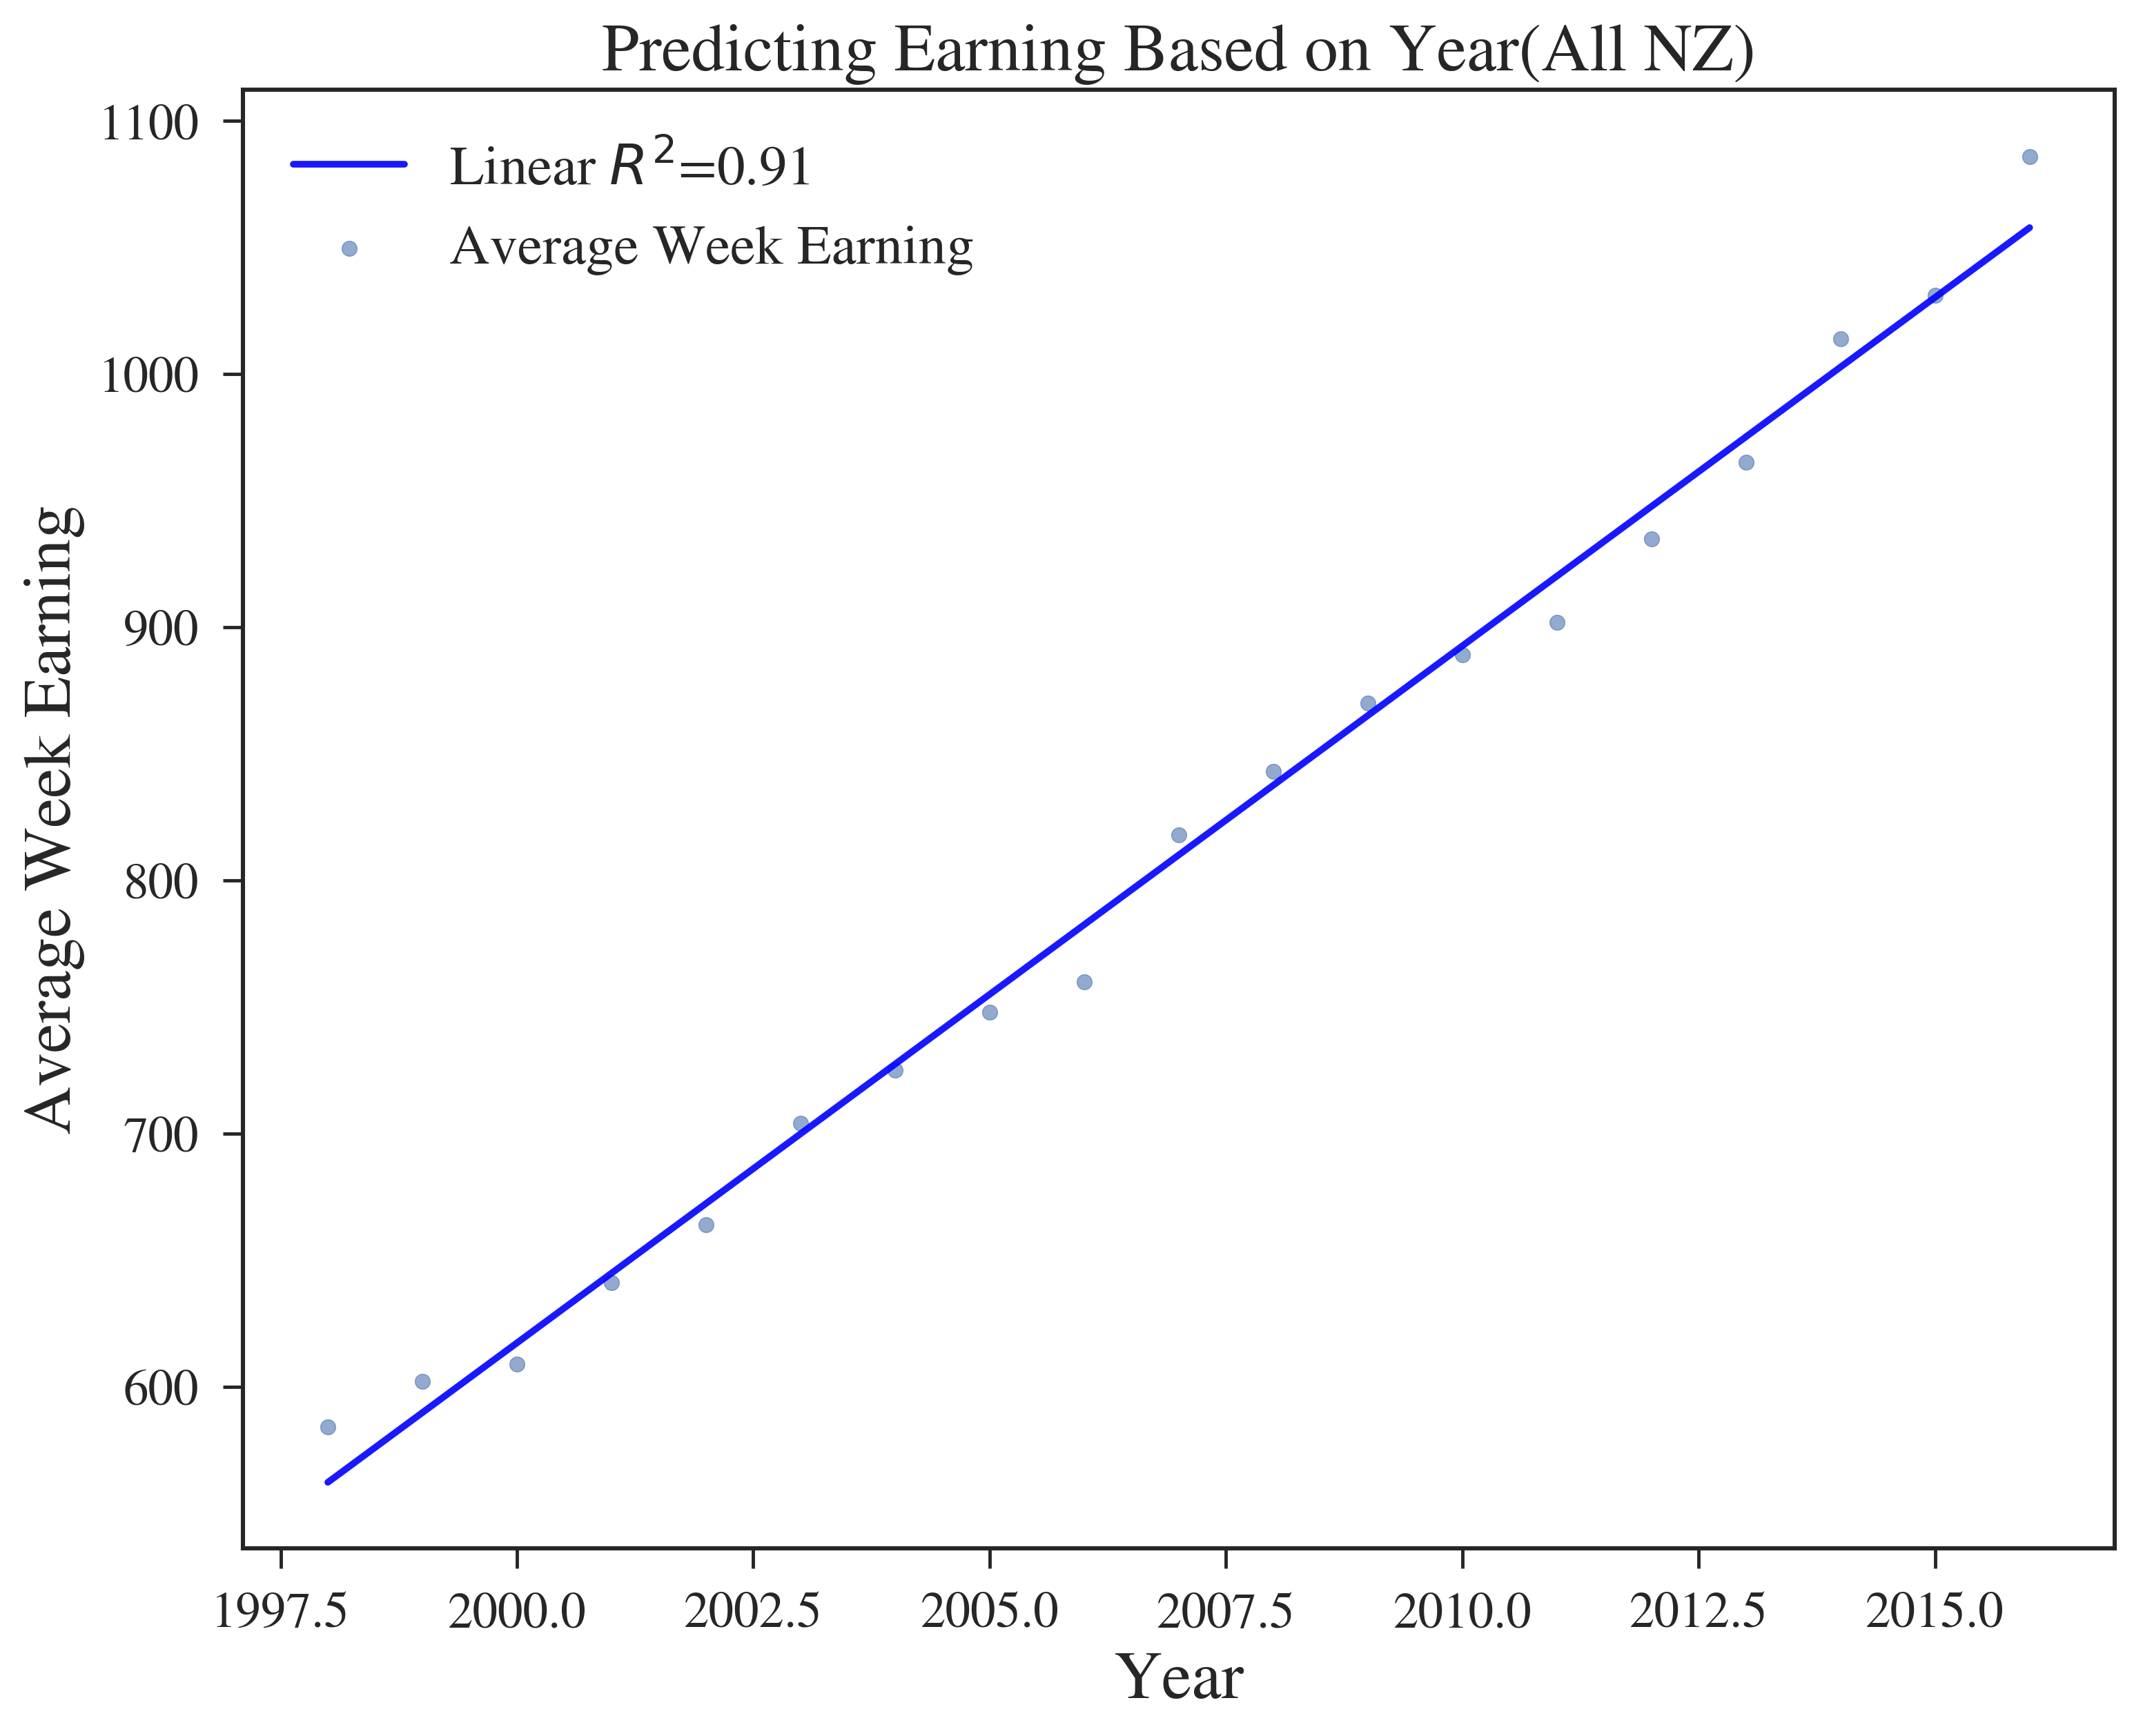

In [22]:
x = pd.DataFrame({'Year': np.linspace(earning_populattion_data['Year'].min(), earning_populattion_data['Year'].max(), len( earning_populattion_data['Year']))})

#generate the model which uses the course work score to predict the exan mark - the ols() return the generated model
earning_mod = smf.ols(formula='Total_awe ~ 1 + Year', data=earning_populattion_data.dropna()).fit()

#plot the actual data
plt.scatter(earning_populattion_data.Year, earning_populattion_data.Total_awe, s=20, alpha=0.6, label= 'Average Week Earning')
plt.xlabel('Year'); plt.ylabel('Average Week Earning')
plt.plot(earning_populattion_data.Year, earning_mod.predict(x), 'b-',  label='Linear $R^2$=%.2f' % mod.rsquared, alpha=0.9)

#give the figure a meaningful legend
plt.legend(loc='upper left', framealpha=0.5, prop={'size':'small'})
plt.title("Predicting Earning Based on Year(All NZ)", fontsize=20)


earning_mod.summary()

### Data Analysis - Population Growth Rate

As the previous population model is not reliable, we have to seek for another approach. Here we can collect historical population growth rate data, which could used to predict growth rate, then the population could be calculated.

In [23]:
# Get population growth rate data of New Zealand from web
url = 'http://www.multpl.com/new-zealand-population-growth-rate/table/by-year'
r = requests.get(url)
scraping_html = BeautifulSoup(r.content,'html.parser')
html_table = scraping_html.find_all("table", {"id":"datatable"})
df = pd.read_html(str(html_table))
population_growth_data = df[0]
print 'Original population growth table'
population_growth_data.head(5)       


Original population growth table


0                       1
0          Date  \n\n Value\n \nValue\n
1  Dec 31, 2016                 2.09%\n
2  Dec 31, 2015                 1.89%\n
3  Dec 31, 2014                 1.51%\n
4  Dec 31, 2013                 0.77%\n

In [24]:
import re
def extractYear(x):
    result=''
    substrs= re.split(',',x)
    if len(substrs) > 0:
         result = substrs[len(substrs) - 1]
    return int(result)
def extractGrowthRate(x):
    result=''
    substrs= re.split('%',x)
    if len(substrs) > 0:
         result = substrs[0]
    return float(result)

In [25]:
# Adjuest population_growth_data for further processing
pgr_columns = ['Year', 'Growth_Rate']
population_growth_data.columns = pgr_columns
# remove the first row and reset index
population_growth_data = population_growth_data[population_growth_data.index!=0]
population_growth_data = population_growth_data.reset_index(drop=True)
population_growth_data['Year'] = population_growth_data['Year'].apply(lambda x: extractYear(x))
population_growth_data['Growth_Rate'] = population_growth_data['Growth_Rate'].apply(lambda x: extractGrowthRate(x))
print 'Processed population growth table'

population_growth_data.head(5)



Processed population growth table


Year  Growth_Rate
0  2016         2.09
1  2015         1.89
2  2014         1.51
3  2013         0.77
4  2012         0.55

In [26]:
population_growth_data = population_growth_data[population_growth_data.Year > 2000]

Construct the kNN model and plot prediction.

/home/yrao/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


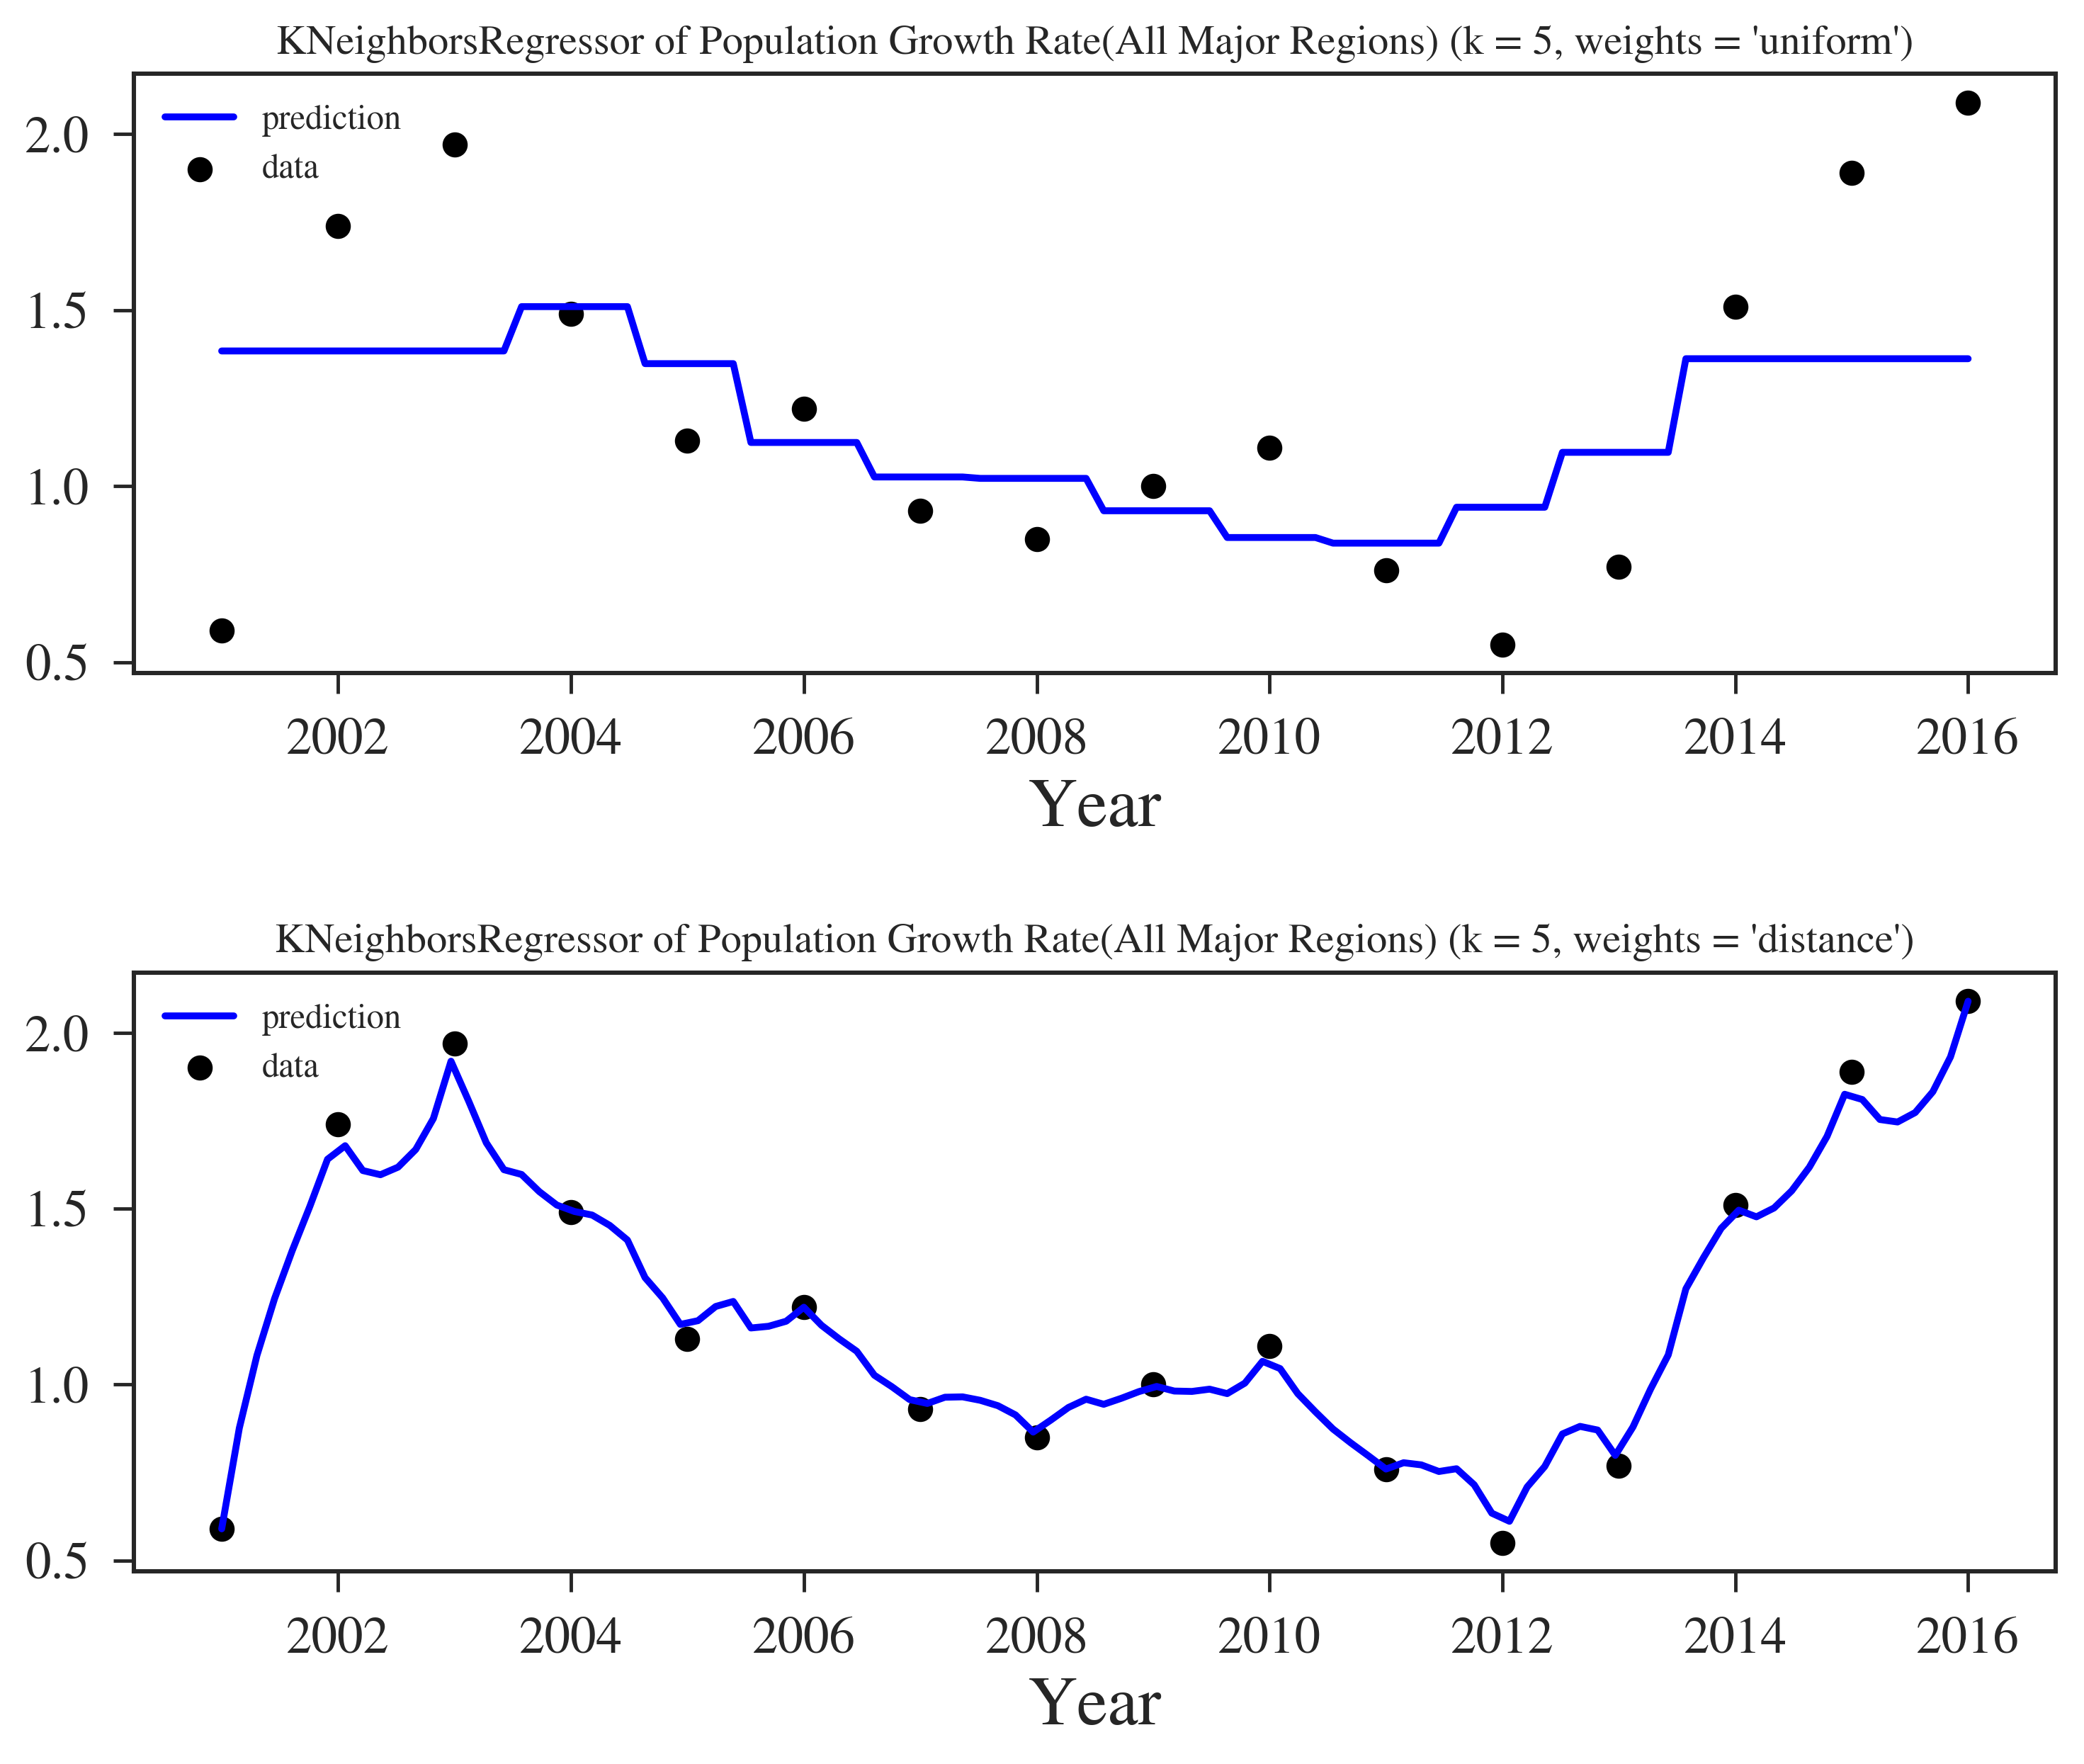

In [27]:
X = population_growth_data.Year.values
X = np.reshape(X, (len(population_growth_data.Year), 1))
y = population_growth_data.Growth_Rate
y = np.reshape(y, (len(population_growth_data.Growth_Rate), 1))

x = np.linspace(population_growth_data.Year.min(), population_growth_data.Year.max(), 100)[:, np.newaxis]
n_neighbors = 5

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    population_growth_rate_mod =  knn.fit(X, y)
    y_hat = population_growth_rate_mod.predict(x)
    
    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot(x, y_hat, c='b', label='prediction')
    plt.axis('tight')
    plt.xlabel('Year')
    #plt.ylabel('Total')
    plt.legend(loc='upper left')
    plt.title("KNeighborsRegressor of Population Growth Rate(All Major Regions) (k = %i, weights = '%s')" % (n_neighbors, weights))
    plt.subplots_adjust( hspace=0.5)
    
plt.show()


From the 'distance' kNN model, the population growth rate of 2017 could be predicted.

# Relationship Analysis

## House Price and Earning - Regression Model

The earning data is collected by year while the house price data is collected by month, so adjust the house price data first to match them

In [28]:
# House price data is from 2013 to 2017, earning data is from 1999 to 2016, so the data from 2013 to 2016 would be used.
# Calculate house price by year since the earing data is collected by year
columns = df_house_price.columns
NZPrices = []
AKLPrices = []
for i in range(0,4):  #4 years
    NZPrice_year = 0
    AKLPrice_year = 0
    for j in range(0,12): # 12 months 
        column_name = columns[1 + i*12 + j]
        NZprice = df_house_price[df_house_price.Area == 'New Zealand'][column_name]
        NZPrice_year += NZprice.values[0]
        AKLprice = df_house_price[df_house_price.Area == 'Auckland City'][column_name]
        AKLPrice_year += AKLprice.values[0]
    NZPrice_year = NZPrice_year/12
    AKLPrice_year = AKLPrice_year/12
    NZPrices.append(NZPrice_year)
    AKLPrices.append(AKLPrice_year)
print NZPrices,AKLPrices       


[443636, 476352, 525629, 593192] [767371, 852347, 1013473, 1152744]


In [29]:
earning_populattion_data.head(5)

Year  Total_awe Total_mwe  Total_nop Northland_awe Northland_mwe  \
0  1998        584       518     1693.8           474           440   
1  1999        602       520     1734.8           540           478   
2  2000        609       537     1757.2           487           438   
3  2001        641       560     1813.3           542           499   
4  2002        664       575     1878.9           574           496   

  Northland_nop  Auckland_awe Auckland_mwe  Auckland_nop Waikato_awe  \
0          53.4         662.0          575         540.4         559   
1          51.9         665.0          575         555.4         541   
2            57         701.0          600         555.5         561   
3          57.1         721.0          600         572.2         597   
4          59.2         743.0          624         598.6         633   

  Waikato_mwe Waikato_nop BoP_awe BoP_mwe BoP_nop GHB_awe GHB_mwe GHB_nop  \
0         518       152.8     545     500      98     535     476    76.9   
1         484       161.3     569     500    99.8     535     460    81.7   
2         520         169     526     480     105     539     493      82   
3         537       166.4     591     520     102     576     520    83.5   
4         575       176.4     597     543   108.8     597     540      86   

  Taranaki_awe Taranaki_mwe Taranaki_nop Manawatu-Wanganui_awe  \
0          545          500         44.3                   472   
1          533          460         46.2                   493   
2          543          479         44.6                   535   
3          597          537         47.2                   586   
4          602          519         51.9                   588   

  Manawatu-Wanganui_mwe Manawatu-Wanganui_nop Wellington_awe Wellington_mwe  \
0                   430                  91.8            661            575   
1                   460                  95.5            721            610   
2                   480                  90.9            679            595   
3                   518                  95.5            705            614   
4                   506                 100.1            750            640   

  Wellington_nop NTMWC_awe NTMWC_mwe NTMWC_nop Canterbury_awe Canterbury_mwe  \
0          214.5       473       435      73.2            508            462   
1          206.1       491       440      73.1            578            498   
2            220       517       480      74.3            575            500   
3          230.3       548       500      78.8            575            520   
4          227.9       594       534      78.3            607            537   

  Canterbury_nop Otago_awe Otago_mwe Otago_nop Southland_awe Southland_mwe  \
0          216.5       517       480      87.7           620           537   
1          232.3       519       468      85.4           528           450   
2          231.8       489       448      84.6           554           527   
3          248.8       560       510      86.7           653           550   
4            255       552       504        92           637           575   

  Southland_nop  
0          44.3  
1          46.2  
2          42.5  
3          44.8  
4          44.7

In [30]:
price_earning_data = earning_populattion_data[earning_populattion_data.Year>2012].iloc[:,[0,1,7]]
price_earning_data['NZ_Price'] = NZPrices
price_earning_data['AKL_Price'] = AKLPrices

print price_earning_data

    Year  Total_awe  Auckland_awe  NZ_Price  AKL_Price
15  2013        965        1037.0    443636     767371
16  2014       1014        1090.0    476352     852347
17  2015       1031        1115.0    525629    1013473
18  2016       1086        1180.0    593192    1152744


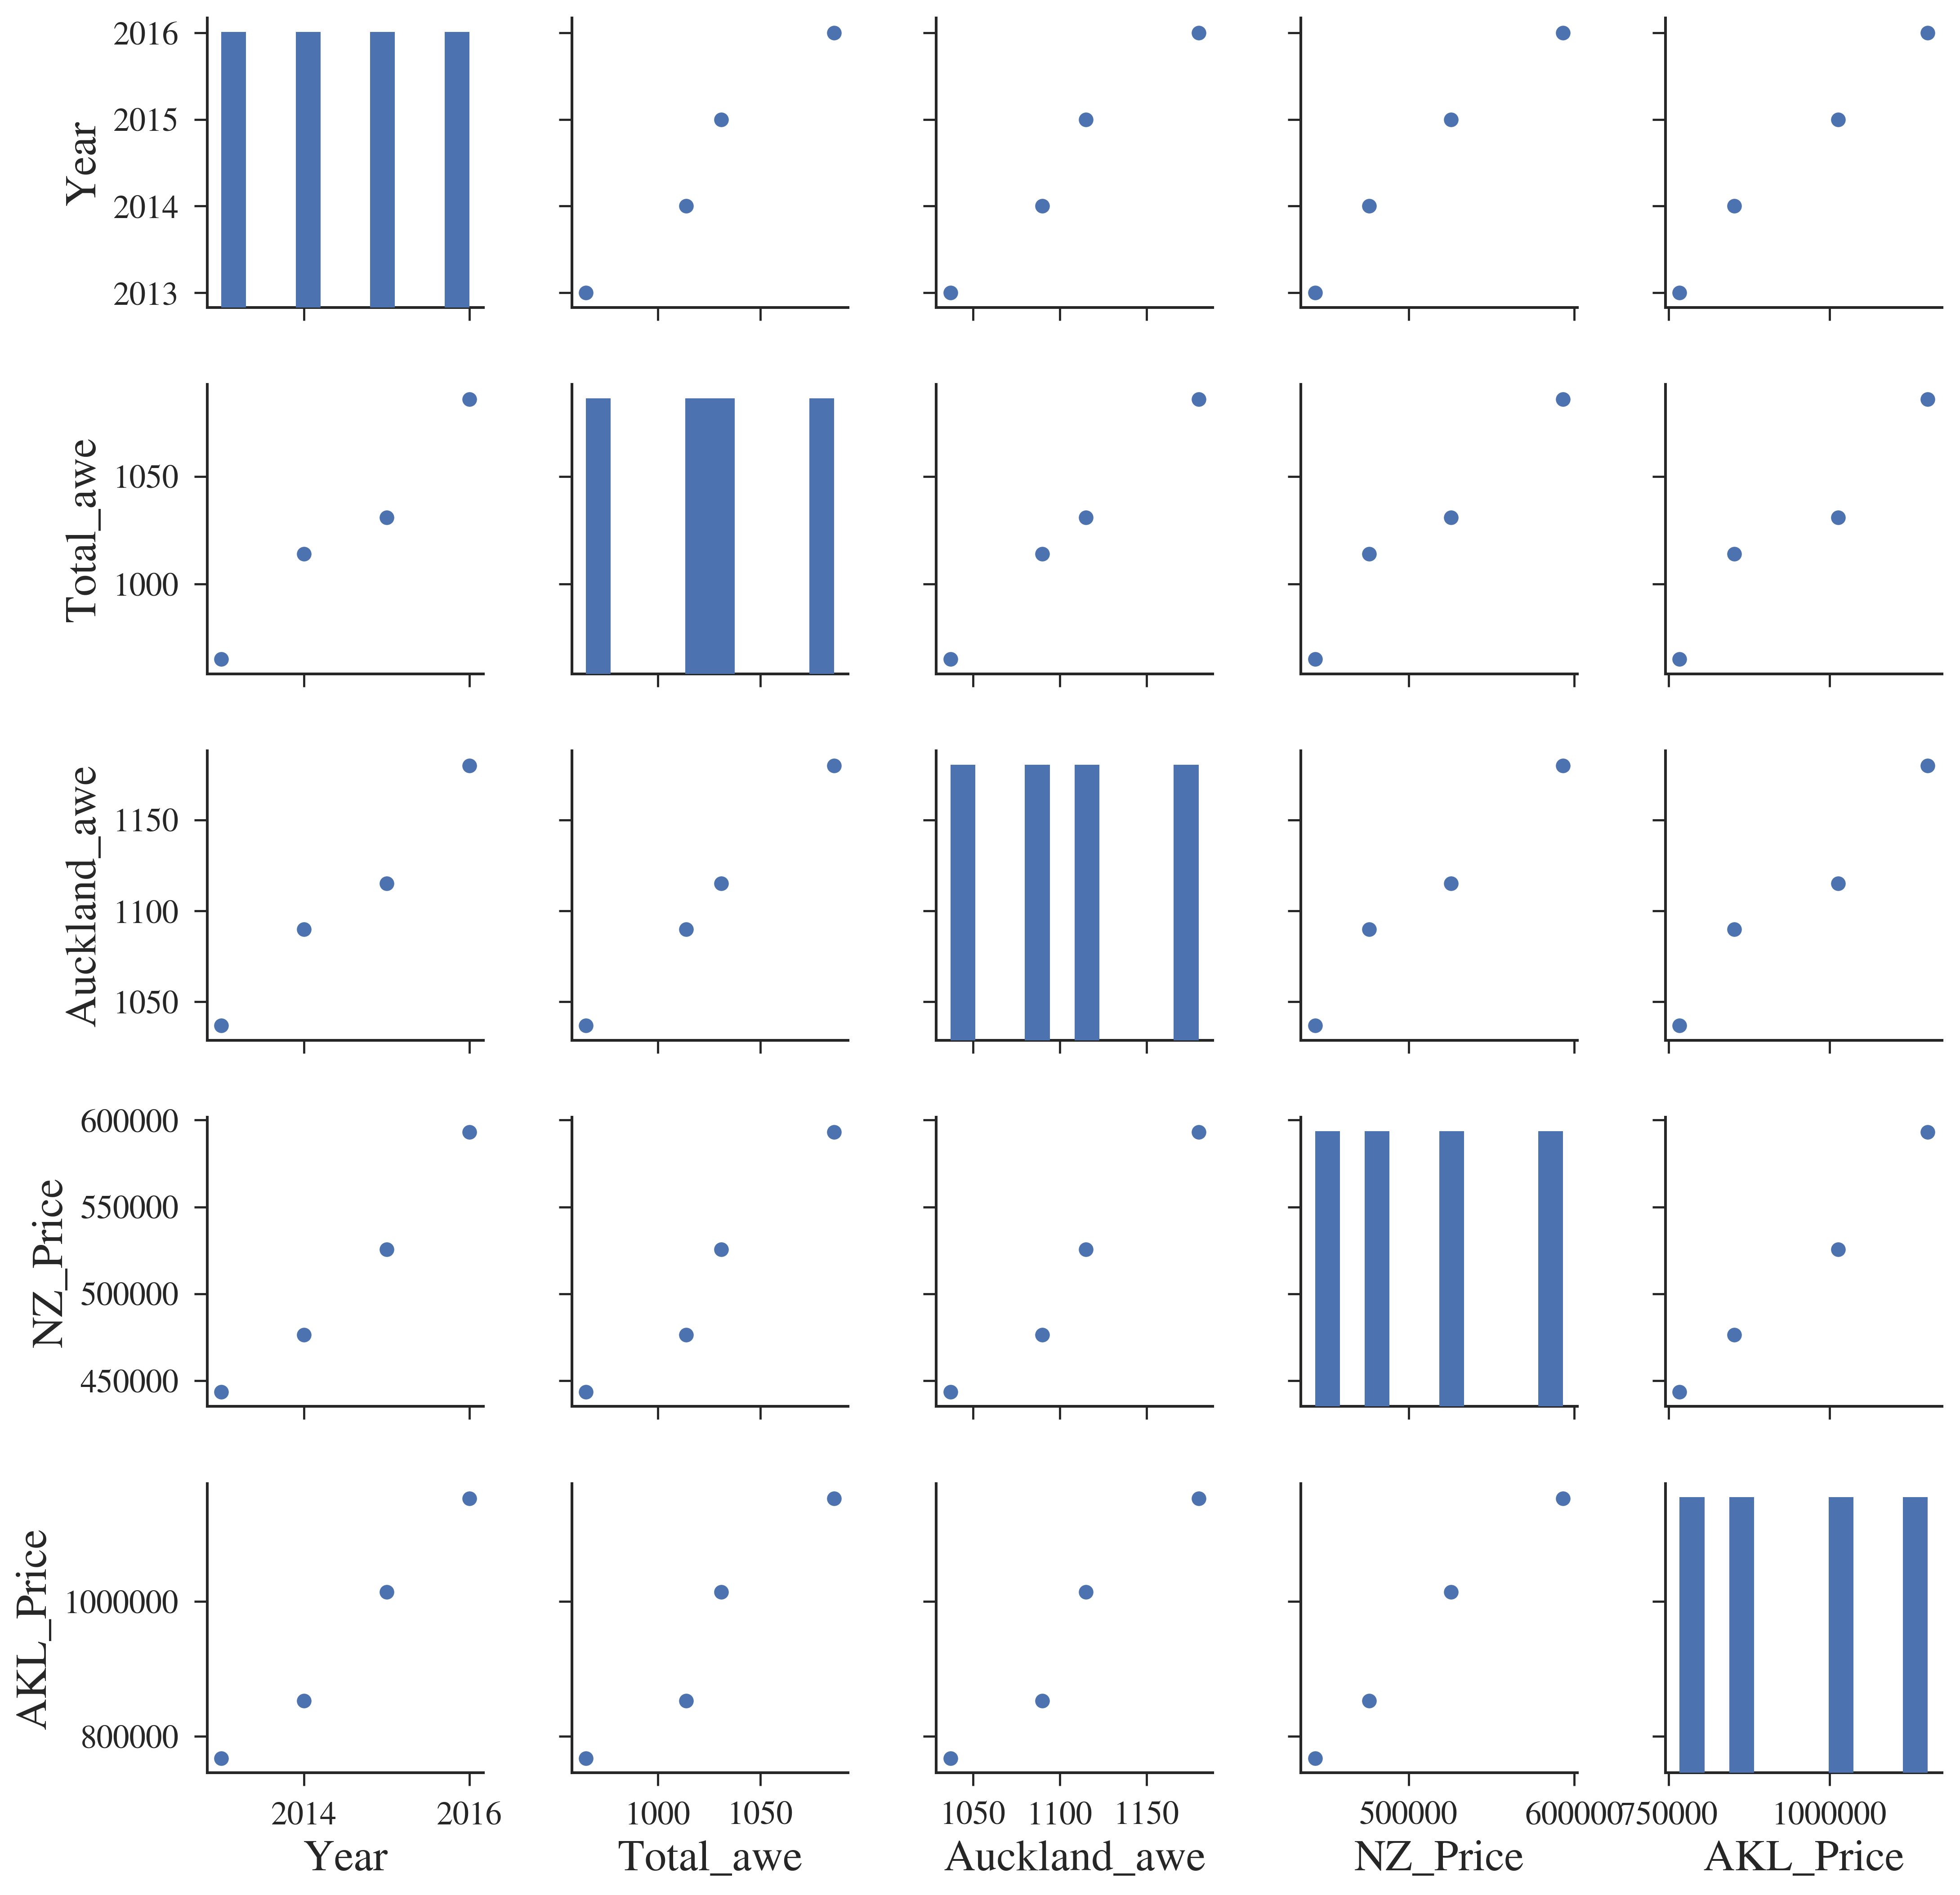

In [31]:
sns.pairplot(price_earning_data.dropna())
sns.plt.show()

In [32]:
price_earning_data.corr()

Year  Total_awe  Auckland_awe  NZ_Price  AKL_Price
Year          1.000000   0.982861      0.987283  0.987971   0.993058
Total_awe     0.982861   1.000000      0.999160  0.977023   0.965837
Auckland_awe  0.987283   0.999160      1.000000  0.984934   0.974844
NZ_Price      0.987971   0.977023      0.984934  1.000000   0.995010
AKL_Price     0.993058   0.965837      0.974844  0.995010   1.000000

The pairplot figure and correlation table show that the house price have a strong relationship with earning, try to figure out a model to represent this relationship.

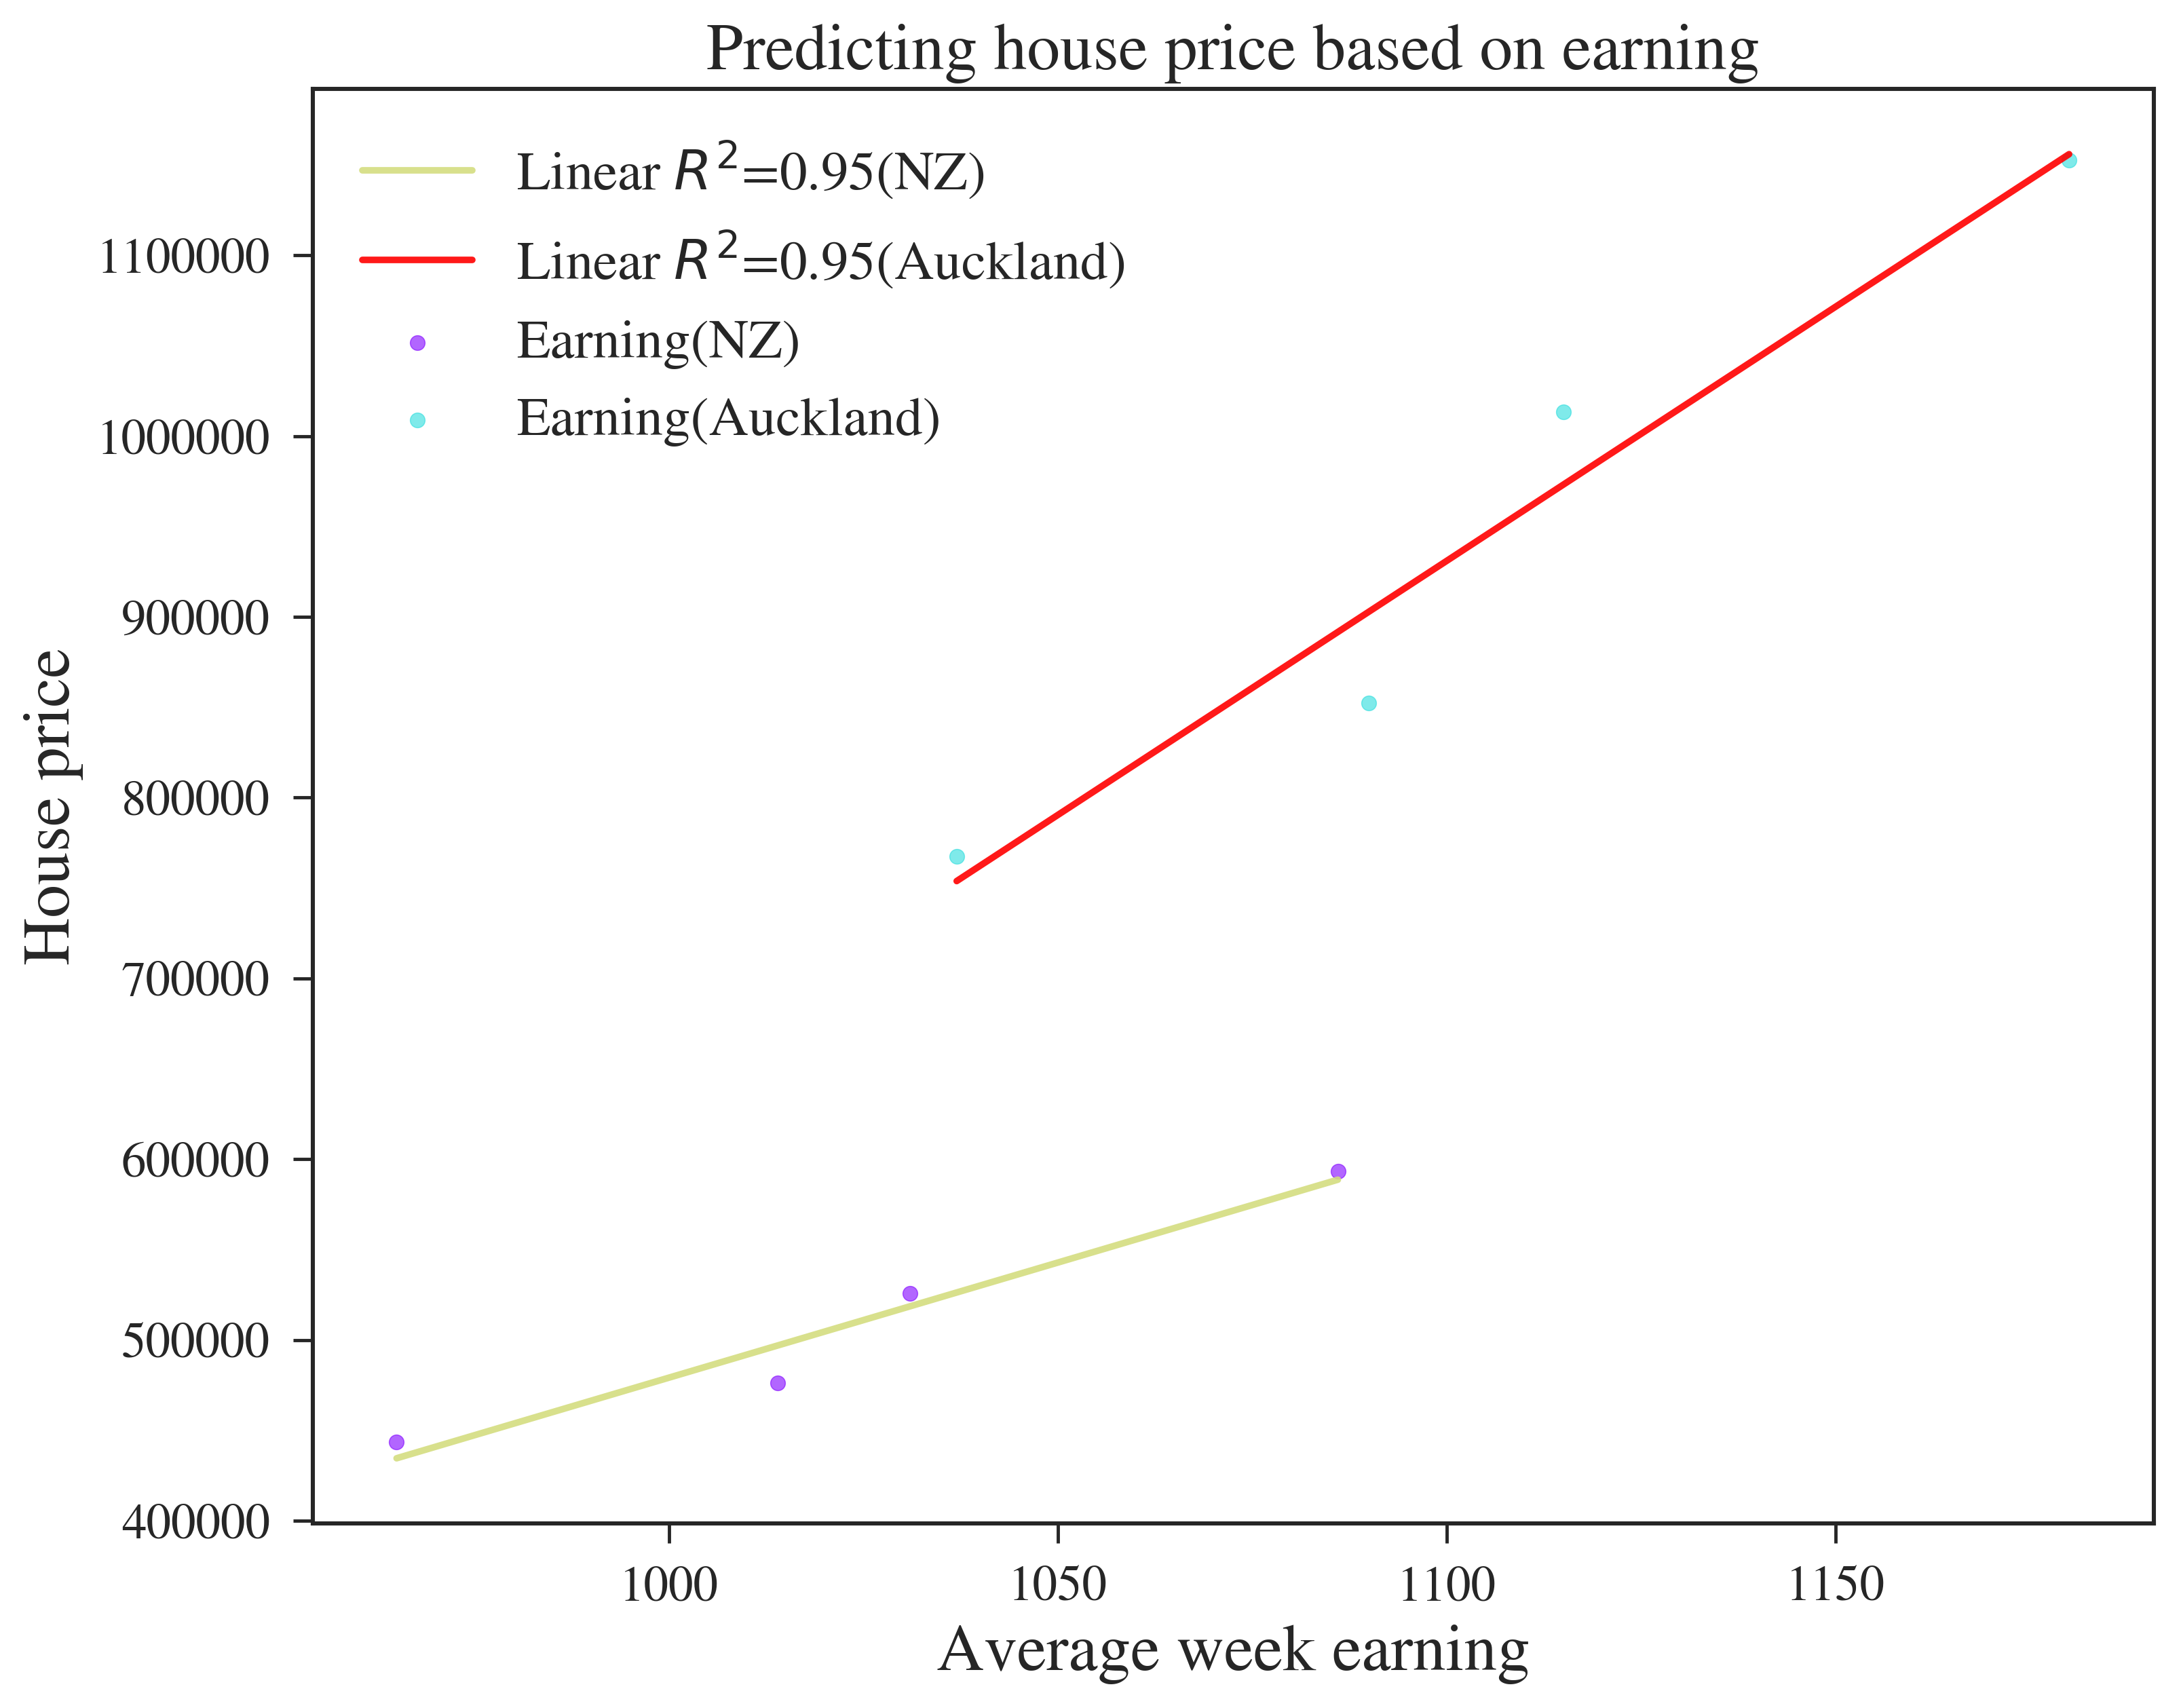

In [33]:
#generate the x-axis values that are in range for the CW values
import matplotlib.cm as cm
colors = iter(cm.rainbow(np.linspace(0, 1, 4)))
NZ_x = pd.DataFrame({'Total_awe': np.linspace(price_earning_data.Total_awe.min(), price_earning_data.Total_awe.max(), len(price_earning_data.Total_awe))})
AKL_x = pd.DataFrame({'Auckland_awe': np.linspace(price_earning_data.Auckland_awe.min(), price_earning_data.Auckland_awe.max(), len(price_earning_data.Auckland_awe))})

NZ_mod = smf.ols(formula='NZ_Price ~ 1 + Total_awe', data=price_earning_data.dropna()).fit()
AKL_mod = smf.ols(formula='AKL_Price ~ 1 + Auckland_awe', data=price_earning_data.dropna()).fit()

#plot the actual data
plt.scatter(price_earning_data.Total_awe, price_earning_data.NZ_Price, s=20, alpha=0.6,label='Earning(NZ)',color=next(colors))
plt.scatter(price_earning_data.Auckland_awe, price_earning_data.AKL_Price, s=20, alpha=0.6,label='Earning(Auckland)',color=next(colors))

plt.xlabel('Average week earning'); plt.ylabel('House price')
#render the regression line by predicting the ys using the generated model from above
plt.plot(NZ_x.Total_awe, NZ_mod.predict(NZ_x), 'b-', label='Linear $R^2$=%.2f(NZ)' % NZ_mod.rsquared, alpha=0.9,color=next(colors))
plt.plot(AKL_x.Auckland_awe, AKL_mod.predict(AKL_x), 'b-', label='Linear $R^2$=%.2f(Auckland)' % AKL_mod.rsquared, alpha=0.9,color=next(colors))
#give the figure a meaningful legend
plt.legend(loc='upper left', framealpha=0.5, prop={'size':'small'})
plt.title("Predicting house price based on earning", fontsize=20)


Both Auckland and all NZ regions follows a linear model, it could be an evidence that the house price has a linear relationship with earning.

## House Price and Population - Regression

### Prepare Data

In [34]:
price_population_data = earning_populattion_data[earning_populattion_data.Year>2012].iloc[:,[0,3,9]]

price_population_data['NZ_Price'] = NZPrices
price_population_data['AKL_Price'] = AKLPrices

print price_population_data

    Year  Total_nop  Auckland_nop  NZ_Price  AKL_Price
15  2013     2154.2         708.3    443636     767371
16  2014     2234.5         748.8    476352     852347
17  2015     2297.6         776.9    525629    1013473
18  2016     2433.3         836.9    593192    1152744


### Data Analysis

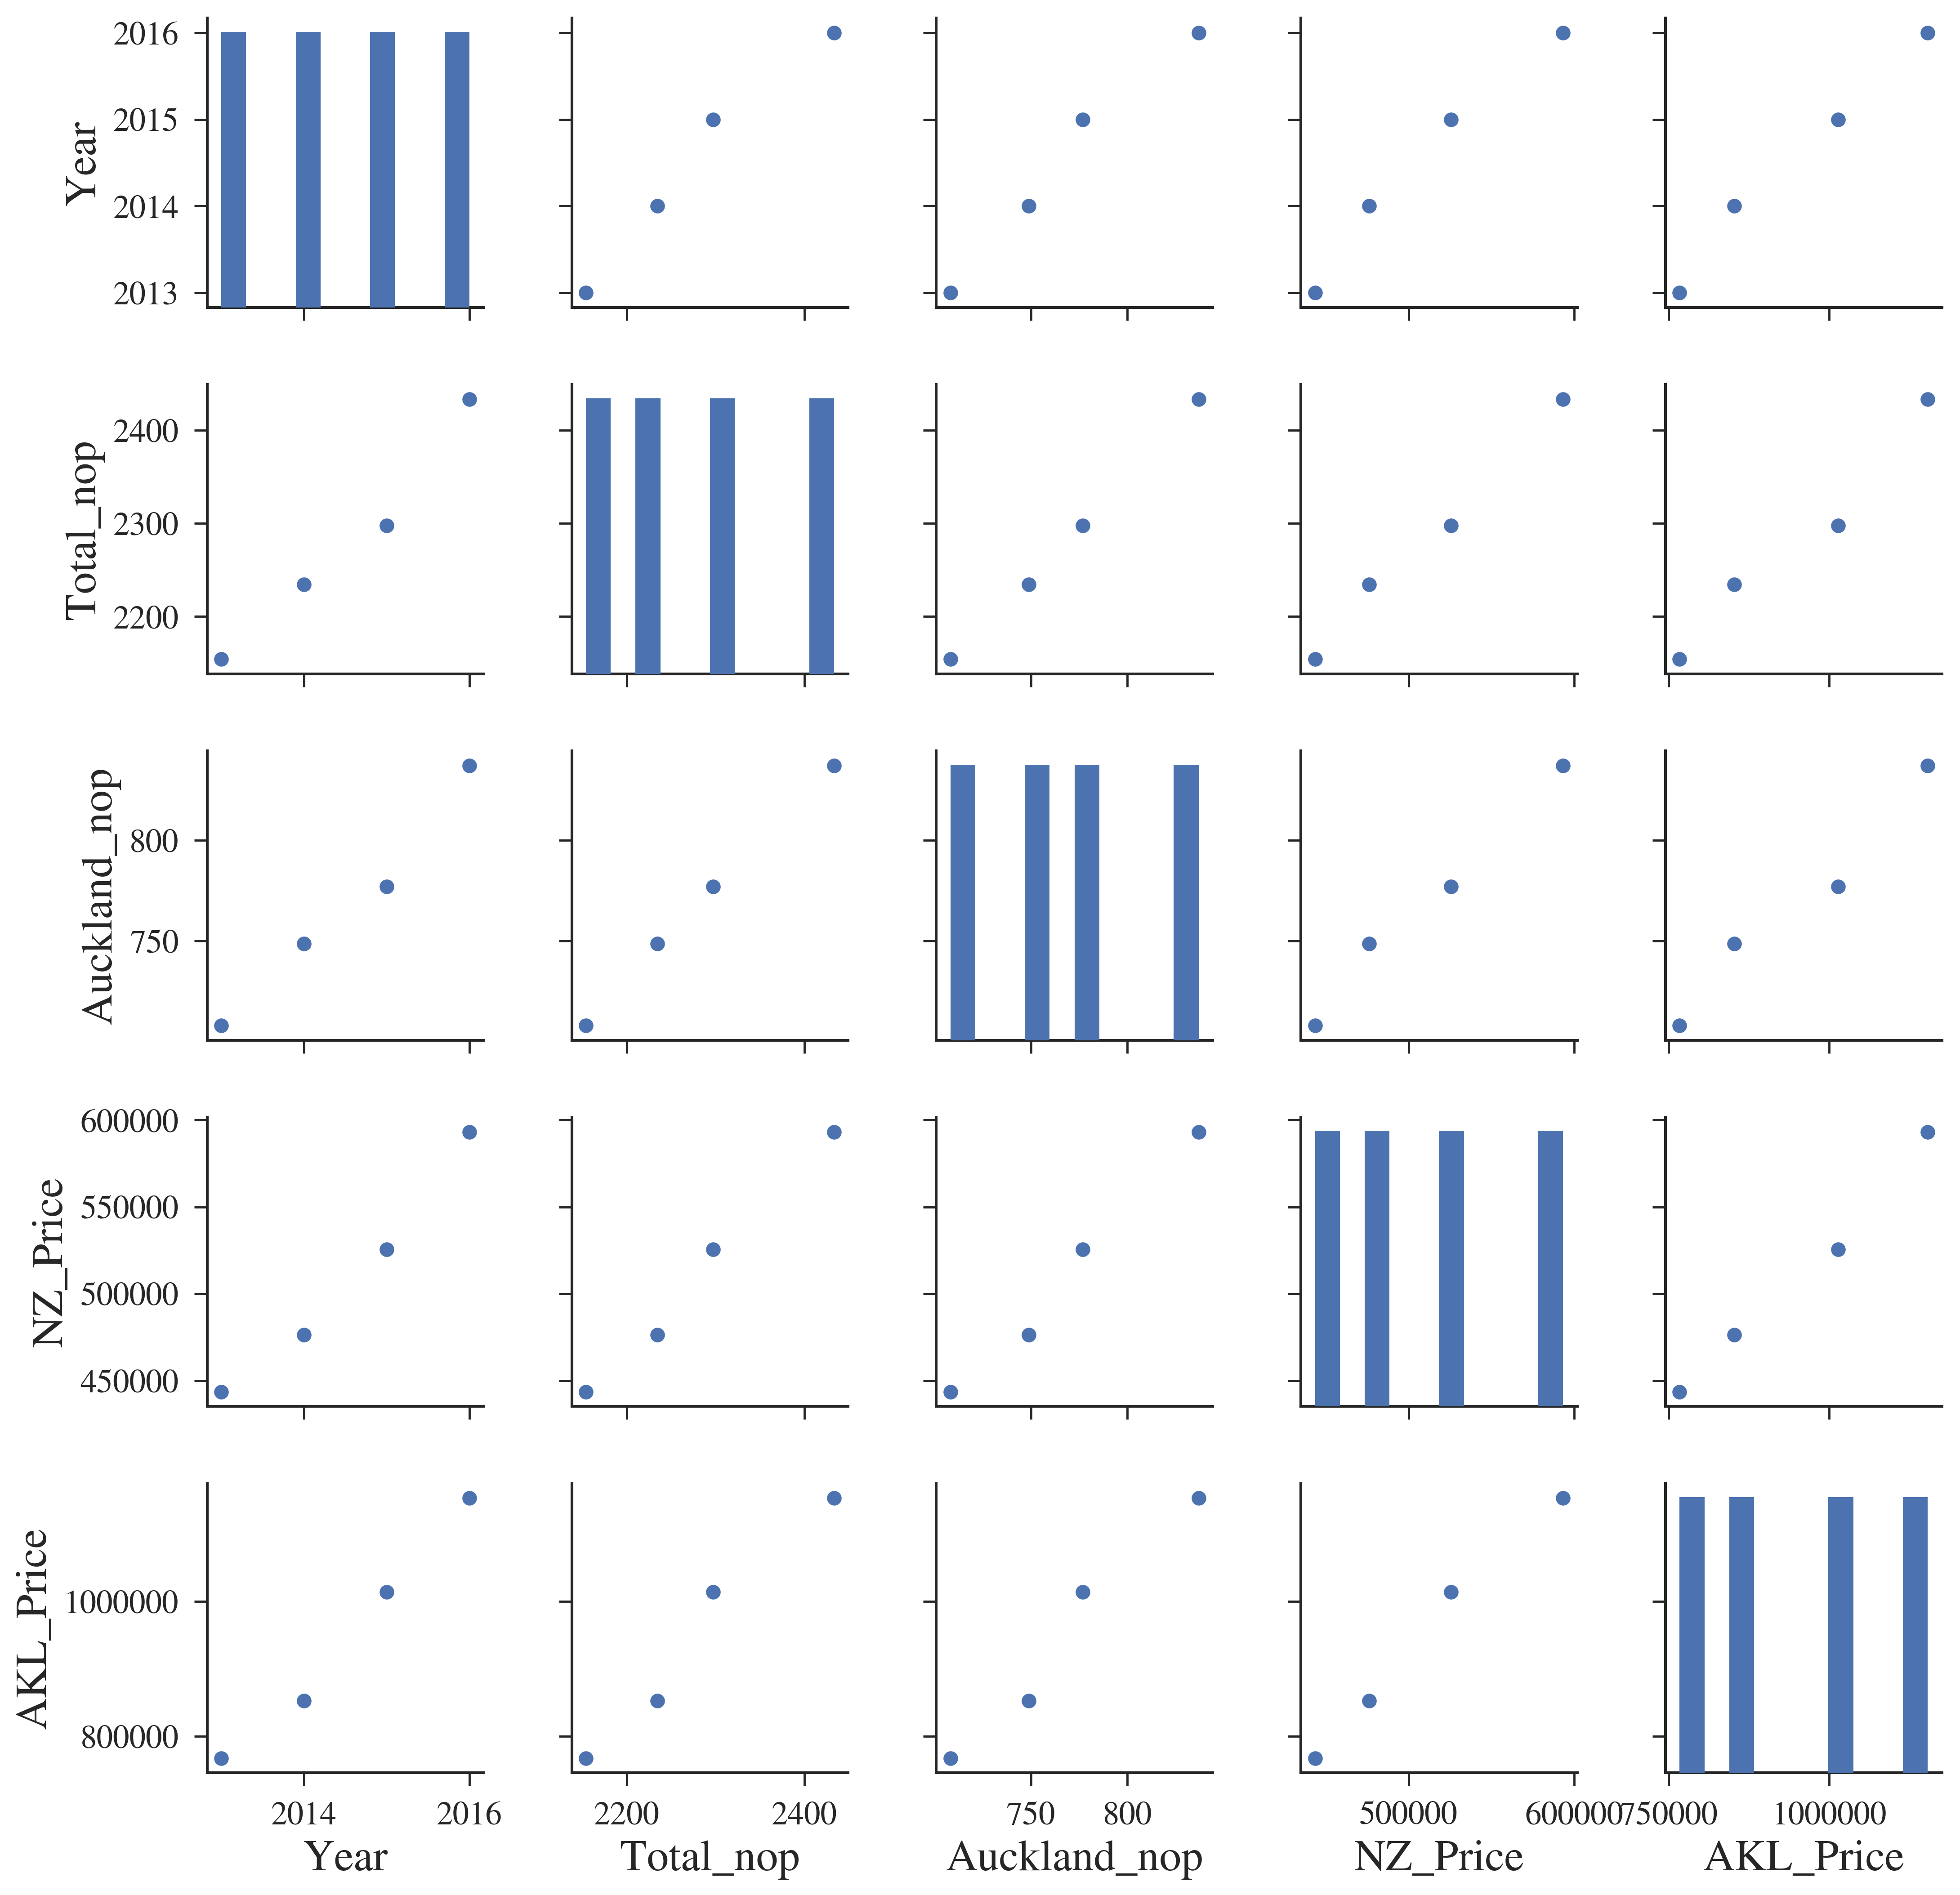

In [35]:
sns.pairplot(price_population_data.dropna())
sns.plt.show()

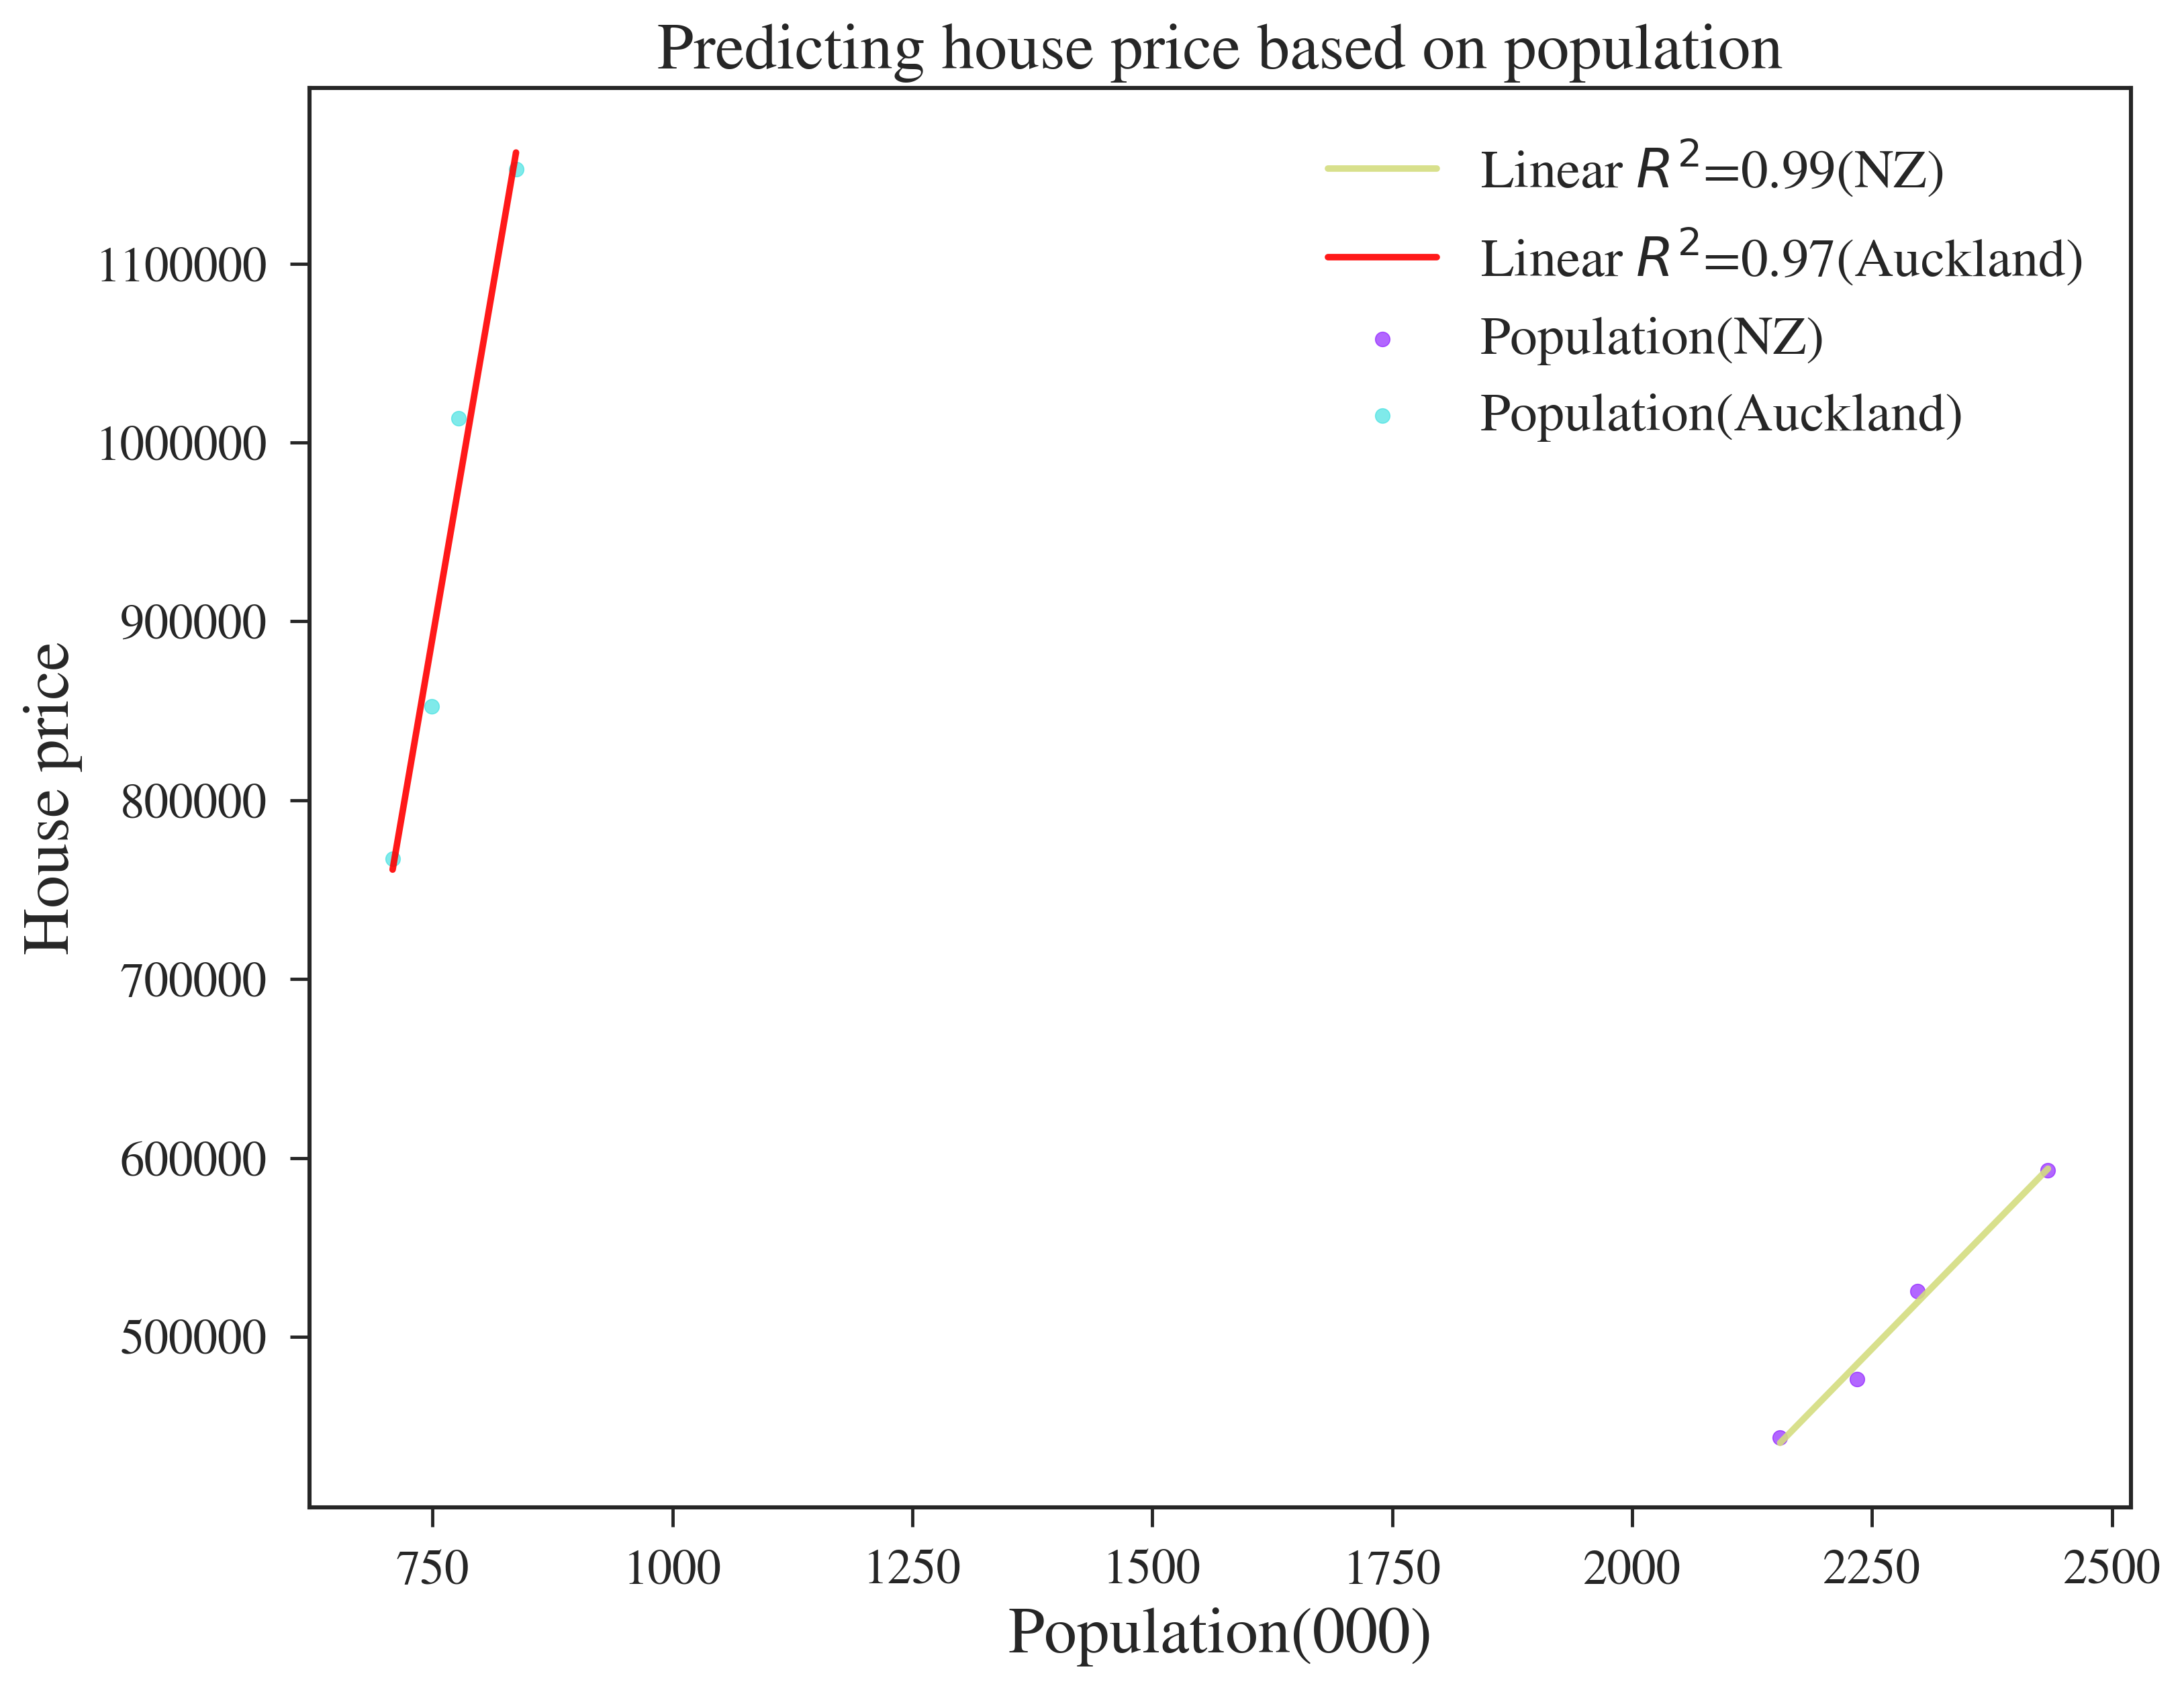

In [36]:
#generate the x-axis values that are in range for the CW values
import matplotlib.cm as cm
colors = iter(cm.rainbow(np.linspace(0, 1, 4)))
NZ_x = pd.DataFrame({'Total_nop': np.linspace(price_population_data.Total_nop .min(), price_population_data.Total_nop .max(), len(price_population_data.Total_nop ))})
AKL_x = pd.DataFrame({'Auckland_nop': np.linspace(price_population_data.Auckland_nop.min(), price_population_data.Auckland_nop.max(), len(price_population_data.Auckland_nop))})


NZ_mod = smf.ols(formula='NZ_Price ~ 1 + Total_nop', data=price_population_data.dropna()).fit()
AKL_mod = smf.ols(formula='AKL_Price ~ 1 + Auckland_nop', data=price_population_data.dropna()).fit()

#plot the actual data
plt.scatter(price_population_data.Total_nop, price_population_data.NZ_Price, s=20, alpha=0.6,label='Population(NZ)',color=next(colors))
plt.scatter(price_population_data.Auckland_nop, price_earning_data.AKL_Price, s=20, alpha=0.6,label='Population(Auckland)',color=next(colors))

plt.xlabel('Population(000)'); plt.ylabel('House price')
#render the regression line by predicting the ys using the generated model from above
plt.plot(NZ_x.Total_nop, NZ_mod.predict(NZ_x), 'b-', label='Linear $R^2$=%.2f(NZ)' % NZ_mod.rsquared, alpha=0.9,color=next(colors))
plt.plot(AKL_x.Auckland_nop, AKL_mod.predict(AKL_x), 'b-', label='Linear $R^2$=%.2f(Auckland)' % AKL_mod.rsquared, alpha=0.9,color=next(colors))
#give the figure a meaningful legend
plt.legend(loc='upper right', framealpha=0.5, prop={'size':'small'})
plt.title("Predicting house price based on population", fontsize=20)


Similiar with earning, this figure proves that the house price has a linear relationship with popuation, too.

# Population, Earning and House Price Prediction

As investigation above, the house price follows linear model with both population and earning, so we build a linear model including these two factors.

## Construct House Price - Population - Earning Linear Model

In [37]:
# Construct house_price_population_earning_mod
price_earning_population_data = pd.merge(price_earning_data, price_population_data)
print price_earning_population_data


   Year  Total_awe  Auckland_awe  NZ_Price  AKL_Price  Total_nop  Auckland_nop
0  2013        965        1037.0    443636     767371     2154.2         708.3
1  2014       1014        1090.0    476352     852347     2234.5         748.8
2  2015       1031        1115.0    525629    1013473     2297.6         776.9
3  2016       1086        1180.0    593192    1152744     2433.3         836.9


In [38]:
house_price_population_earning_mod = smf.ols(formula='NZ_Price ~ 1 +  Total_awe + Total_nop', data=price_earning_population_data.dropna()).fit()

We have a model to predict house price from population and earning now, if we also know the population and earning in 2017, we can predict the house price. So next we will predict population and earning of 2017.

## Predict Population

As the population does not increase with a good linear model, we need to calculate the population of 2017 from population growth rate via kNN model.


In [39]:
predicted_population_growth_rate_2017 = population_growth_rate_mod.predict([[2017]])
predicted_population_growth_rate_2017 = predicted_population_growth_rate_2017[0][0]
print 'The population growth rate of 2017 is expected to be',predicted_population_growth_rate_2017

The population growth rate of 2017 is expected to be 1.68211678832


In [40]:
population_2016 = earning_populattion_data[earning_populattion_data.Year==2016]['Total_nop'].values[0]
predicted_population_2017 = population_2016 + population_2016 * predicted_population_growth_rate_2017/100.0
print 'The total population of major regions in 2017 is expected to be', predicted_population_2017

The total population of major regions in 2017 is expected to be 2474.23094781


## Predict Earning

The earning data follows linear model well, so we can use earning_mod to predict earning of 2017

In [41]:
x_2017 = pd.DataFrame({'Year':[2017]})
predicted_earning_2017 = earning_mod.predict(x_2017)
predicted_earning_2017 = predicted_earning_2017.values[0]
print 'the average weekly earning in NZ of 2017 is exptected to be', predicted_earning_2017

the average weekly earning in NZ of 2017 is exptected to be 1085.35087719


## Predict House Price

In [42]:
x_2017 = pd.DataFrame({'Total_awe':[predicted_earning_2017], 'Total_nop':[predicted_population_2017]})
predicted_house_price_2017 = house_price_population_earning_mod.predict(x_2017).values[0]
print "Average house price of NZ in 2017 is expected to be", predicted_house_price_2017

Average house price of NZ in 2017 is expected to be 631677.424265


# Conclusion

This article collects house price data, population and earning data, population growth data from three different sources. It analyses the relationship between house price, population and earning, then predict the population of major regions, the average weekly earning and average house price of 2017 seperatly.
The population of major regions in NZ is predicted to be 2474.23094781 thousands, the average weekly earning of 2017 is estimated to be 1085.35087719 and the house price of 2017 is expected to be 631677.424265 NZD.

However, the article has a weakness in predicting house price, that is the average house price data only starts at 2013, is is not enough to construct a robust model for predicting. More historical data is needed to improve the reliability of this article.